
# Adaptive Sampling for Underwater Vertical Profiling using MDP-based Planning

This notebook implements an intelligent sampling strategy for autonomous underwater
vehicles (AUVs) to efficiently reconstruct environmental profiles. The approach
uses Gaussian Process regression for uncertainty estimation and Real-Time Dynamic
Programming (RTDP) for adaptive path planning.



In [1]:
# Standard libraries
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict
from enum import Enum
from datetime import datetime
import pickle
import time
import os

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d

# ============================================
# PLOT STYLE CONFIGURATION
# ============================================
PLOT_STYLE = {
    # Font sizes
    'title_size': 14,
    'label_size': 12,
    'tick_size': 10,
    'legend_size': 10,
    'annotation_size': 10,
    
    # Colors
    'cmap_o2': 'viridis',           # Colormap for O2 data
    'cmap_density': 'YlOrRd',       # Colormap for density plots
    'cmap_variance': 'plasma',      # Colormap for variance
    'color_samples': '#E63946',     # Red for sample points
    'color_trajectory': '#457B9D',  # Blue for trajectory lines
    'color_ground_truth': '#2A9D8F',# Teal for ground truth
    'color_prediction': '#E76F51',  # Coral for predictions
    'color_bars': '#457B9D',        # Steel blue for bar charts
    
    # Markers and lines
    'sample_size': 15,
    'sample_alpha': 0.7,
    'trajectory_width': 1.0,
    'trajectory_alpha': 0.7,
    'grid_alpha': 0.3,
    
    # Figure sizes
    'fig_single': (12, 6),
    'fig_wide': (14, 6),
    'fig_square': (8, 8),
    'fig_multi': (14, 10),
    
    # DPI for saving
    'dpi': 150
}

def style_axis(ax, title, xlabel, ylabel, grid=True, invert_y=False):
    """Apply consistent styling to an axis."""
    ax.set_title(title, fontsize=PLOT_STYLE['title_size'], fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=PLOT_STYLE['label_size'])
    ax.set_ylabel(ylabel, fontsize=PLOT_STYLE['label_size'])
    ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    if grid:
        ax.grid(True, alpha=PLOT_STYLE['grid_alpha'])
    if invert_y:
        ax.invert_yaxis()

print("Plot style configuration loaded.")

Plot style configuration loaded.


## Data and Pre-Processing

In [2]:
# Load and preprocess oceanographic data
# Data source: Year-long profiler measurements from Oregon coast

year_1 = pd.read_csv('year_1.csv')

# Define time window: October 1 - December 31, 2021 (3-month subset)
start_2021 = datetime(2021, 1, 1)
oct1_2021 = datetime(2021, 10, 1)
jan1_2022 = datetime(2022, 1, 1)

oct1_offset = (oct1_2021 - start_2021).total_seconds()
jan1_offset = (jan1_2022 - start_2021).total_seconds()

# Filter to 3-month window
three_month_full = year_1[
    (year_1['all_time'] >= oct1_offset) &
    (year_1['all_time'] < jan1_offset)
].reset_index(drop=True)

# Convert time from seconds to minutes, normalized to start at 0
three_month_full['all_time'] = three_month_full['all_time'] / 60.0
three_month_full['all_time'] = three_month_full['all_time'] - three_month_full['all_time'].min()

print(f"Full 3-month dataset: {len(three_month_full):,} observations")

# Subsample to manageable size while preserving temporal distribution. This project samples 10000 points due to compute limitations, but the entire dataset has 1.5 million points to experiment with.
TARGET_SIZE = 10000
if len(three_month_full) > TARGET_SIZE:
    three_month = three_month_full.sample(n=TARGET_SIZE, random_state=42).sort_values('all_time').reset_index(drop=True)
else:
    three_month = three_month_full

print(f"Subsampled dataset: {len(three_month):,} observations")
print(three_month.head())


Full 3-month dataset: 1,555,441 observations
Subsampled dataset: 10,000 observations
     all_time   all_lat   all_long   all_depth     all_o2  all_temp
0    0.516667   46.8536 -124.97988  412.910251  58.090415    5.8353
1    6.366667   46.8536 -124.97988  502.786922  34.082393    5.6091
2    6.950000   46.8536 -124.97988  502.786922  33.800930    5.5994
3    7.716667   46.8536 -124.97988  502.757244  34.069744    5.6241
4  290.766667   46.8536 -124.97988  500.956730  33.901223    5.5871


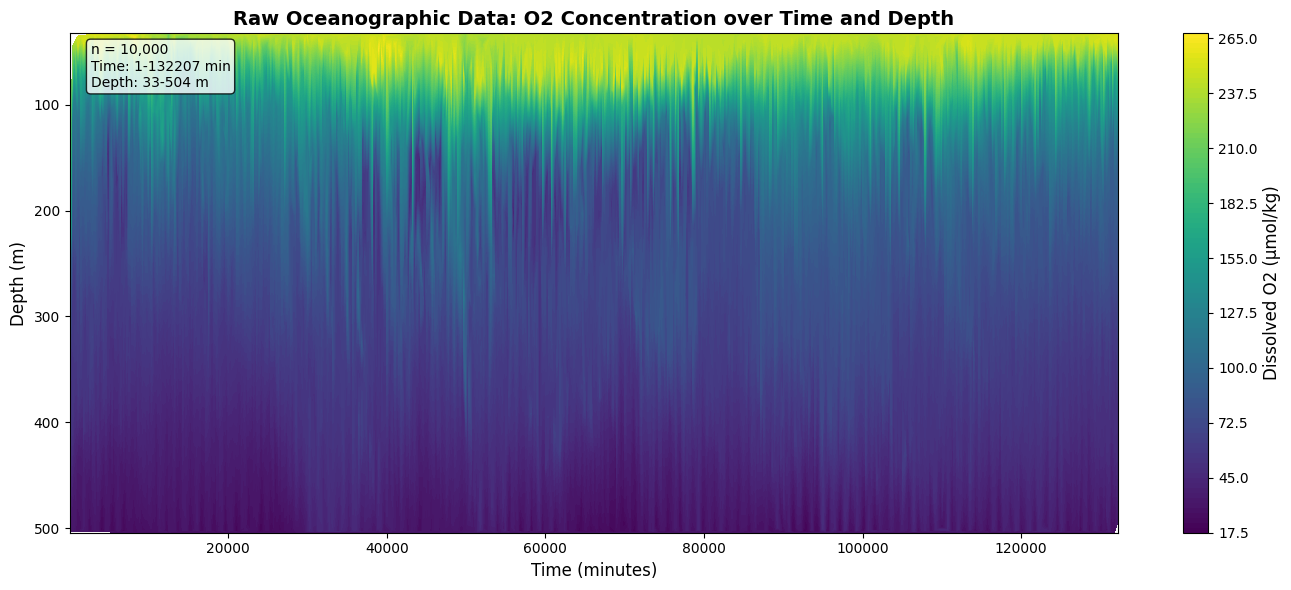

In [8]:
# Visualize raw data: Depth vs Time with O2 as heatmap
def plot_raw_data_heatmap(data, save_path=None):
    """
    Plot the raw oceanographic data as a continuous filled heatmap.
    X-axis: Time, Y-axis: Depth, Color: Dissolved O2
    Uses tricontourf for smooth continuous color variation.
    """
    from matplotlib.tri import Triangulation
    
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_wide'])
    
    # Create triangulation and filled contour plot for continuous colors
    x = data['all_time'].values
    y = data['all_depth'].values
    z = data['all_o2'].values
    
    # Create filled contour plot with many levels for smooth gradients
    contour = ax.tricontourf(x, y, z, levels=100, cmap=PLOT_STYLE['cmap_o2'])
    
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Dissolved O2 (μmol/kg)', fontsize=PLOT_STYLE['label_size'])
    cbar.ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    
    style_axis(ax, 'Raw Oceanographic Data: O2 Concentration over Time and Depth',
               'Time (minutes)', 'Depth (m)', grid=False, invert_y=True)
    
    stats_text = f'n = {len(data):,}\nTime: {data["all_time"].min():.0f}-{data["all_time"].max():.0f} min\nDepth: {data["all_depth"].min():.0f}-{data["all_depth"].max():.0f} m'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=PLOT_STYLE['annotation_size'], verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()

plot_raw_data_heatmap(three_month, save_path='result graphs/raw_data_heatmap.png')


## Gaussian Process
Gaussian Process Regression Model for O2 prediction
Uses a composite kernel (Matern * ExpSineSquared) to capture both
smooth variations and periodic patterns in the dissolved oxygen field.

In [4]:
@dataclass
class GPRConfig:
    """Configuration parameters for GP regression."""
    train_size: int = 3000
    val_frac: float = 0.2
    random_state: int = 42


class GPRModel:
    """
    Gaussian Process Regression model for predicting dissolved oxygen
    as a function of time and depth. Used to esimate uncertainty of the
    environment at each location at a given time and extract variance behaviour
    for each depth.
    """
    
    def __init__(self, data, train_size=3000, test_size=0.2, random_state=42):
        self.data = data
        self.train_size = train_size
        self.test_size = test_size
        self.random_state = random_state
        self.gpr = None
        self.scaler_time = StandardScaler()
        self.scaler_depth = StandardScaler()
        self.scaler_o2 = StandardScaler()

    def prepare_data(self):
        """Prepares and splits the data into scaled train, 
        validation, and test sets.
        """
        total_size = len(self.data)
        np.random.seed(self.random_state)

        train_val_idx = np.random.choice(total_size, size=self.train_size, replace=False)
        train_idx, val_idx = train_test_split(train_val_idx, test_size=self.test_size, random_state=self.random_state)

        self.train_data = self.data[train_idx]
        self.val_data = self.data[val_idx]

        mask = np.ones(total_size, dtype=bool)
        mask[train_val_idx] = False
        self.test_data = self.data[mask]

        self.X_train = self.train_data[:, :2]
        self.y_train = self.train_data[:, 2]
        self.X_val = self.val_data[:, :2]
        self.y_val = self.val_data[:, 2]
        self.X_test = self.test_data[:, :2]
        self.y_test = self.test_data[:, 2]

        self.y_train_raw = self.y_train.copy()

        self.X_train[:, 0] = self.scaler_time.fit_transform(self.X_train[:, 0].reshape(-1, 1)).flatten()
        self.X_train[:, 1] = self.scaler_depth.fit_transform(self.X_train[:, 1].reshape(-1, 1)).flatten()
        self.y_train = self.scaler_o2.fit_transform(self.y_train.reshape(-1, 1)).flatten()

        self.X_val[:, 0] = self.scaler_time.transform(self.X_val[:, 0].reshape(-1, 1)).flatten()
        self.X_val[:, 1] = self.scaler_depth.transform(self.X_val[:, 1].reshape(-1, 1)).flatten()
        self.y_val = self.scaler_o2.transform(self.y_val.reshape(-1, 1)).flatten()

        self.X_test[:, 0] = self.scaler_time.transform(self.X_test[:, 0].reshape(-1, 1)).flatten()
        self.X_test[:, 1] = self.scaler_depth.transform(self.X_test[:, 1].reshape(-1, 1)).flatten()

    def combined_kernel(self, length_scale, periodicity, nu=1.5,
                        length_scale_bounds=(1e-5, 1e5),
                        periodicity_bounds=(1e-5, 1e5)):
        """Combined kernel for GP regression, uses Matern and ExpSineSquared kernels"""
        k1 = Matern(length_scale=length_scale, nu=nu,
                    length_scale_bounds=length_scale_bounds)
        k2 = ExpSineSquared(length_scale=periodicity,
                            periodicity=periodicity,
                            length_scale_bounds=periodicity_bounds,
                            periodicity_bounds=periodicity_bounds)
        return k1 * k2

    def train_model(self):
        """Training GP model"""
        kernel = self.combined_kernel(length_scale=15.0, periodicity=len(self.X_train)/4, nu=1.5)
        self.gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=self.random_state)
        self.gpr.fit(self.X_train, self.y_train)

    def predict(self, input_vals = None):
        """Predicts the O2 values for the given input values."""
        if input_vals is None:
            input_vals = self.X_test
        prediction = self.gpr.predict(input_vals)
        prediction_original_scale = self.scaler_o2.inverse_transform(prediction.reshape(-1, 1))
        self.prediction_original_scale = prediction_original_scale.flatten()
        return self.prediction_original_scale

    def evaluate_model(self):
        """Compute regression metrics on test set."""
        y_test = self.y_test
        y_pred = self.prediction_original_scale

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_test - y_pred))
        return mse, r2, rmse, mae

    def measure_uncertainty(self):
        """Measures uncertainty of GP predictions"""
        y_mean, y_std = self.gpr.predict(self.X_test, return_std=True)
        y_mean_original = self.scaler_o2.inverse_transform(y_mean.reshape(-1, 1)).flatten()
        y_std_original = y_std * self.scaler_o2.scale_
        lower_bound = y_mean_original - 1.96 * y_std_original
        upper_bound = y_mean_original + 1.96 * y_std_original
        return y_mean_original, y_std_original, lower_bound, upper_bound

    def variance_over_depth(self, time_value: float, depth_grid: np.ndarray):
        """Variance across depths at fixed time (ORIGINAL units)"""
        t_scaled = self.scaler_time.transform(np.array([[time_value]]))[0,0]
        d_scaled = self.scaler_depth.transform(depth_grid.reshape(-1,1)).flatten()
        X_query = np.column_stack([np.full_like(d_scaled, t_scaled), d_scaled])
        _, y_std = self.gpr.predict(X_query, return_std=True)
        y_std_orig = y_std * self.scaler_o2.scale_
        return depth_grid, (y_std_orig ** 2)

    def variance_at_point(self, time_value: float, depth_value: float) -> float:
        """Variance at single (time, depth) - ORIGINAL units"""
        _, var_arr = self.variance_over_depth(time_value, np.array([depth_value]))
        return float(var_arr[0])


In [5]:
# Train Gaussian Process model
data_array = three_month[['all_time', 'all_depth', 'all_o2']].to_numpy()

gp_model = GPRModel(data_array, train_size=2000)
gp_model.prepare_data()
gp_model.train_model()
gp_model.predict()

mse, r2, rmse, mae = gp_model.evaluate_model()

In [6]:
# Full evaluation metrics
print(f"GP Model Evaluation:")
print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.2f}")
print(f"  R²:   {r2:.3f}")


GP Model Evaluation:
  MSE:  154.2663
  RMSE: 12.4204
  MAE:  7.83
  R²:   0.964


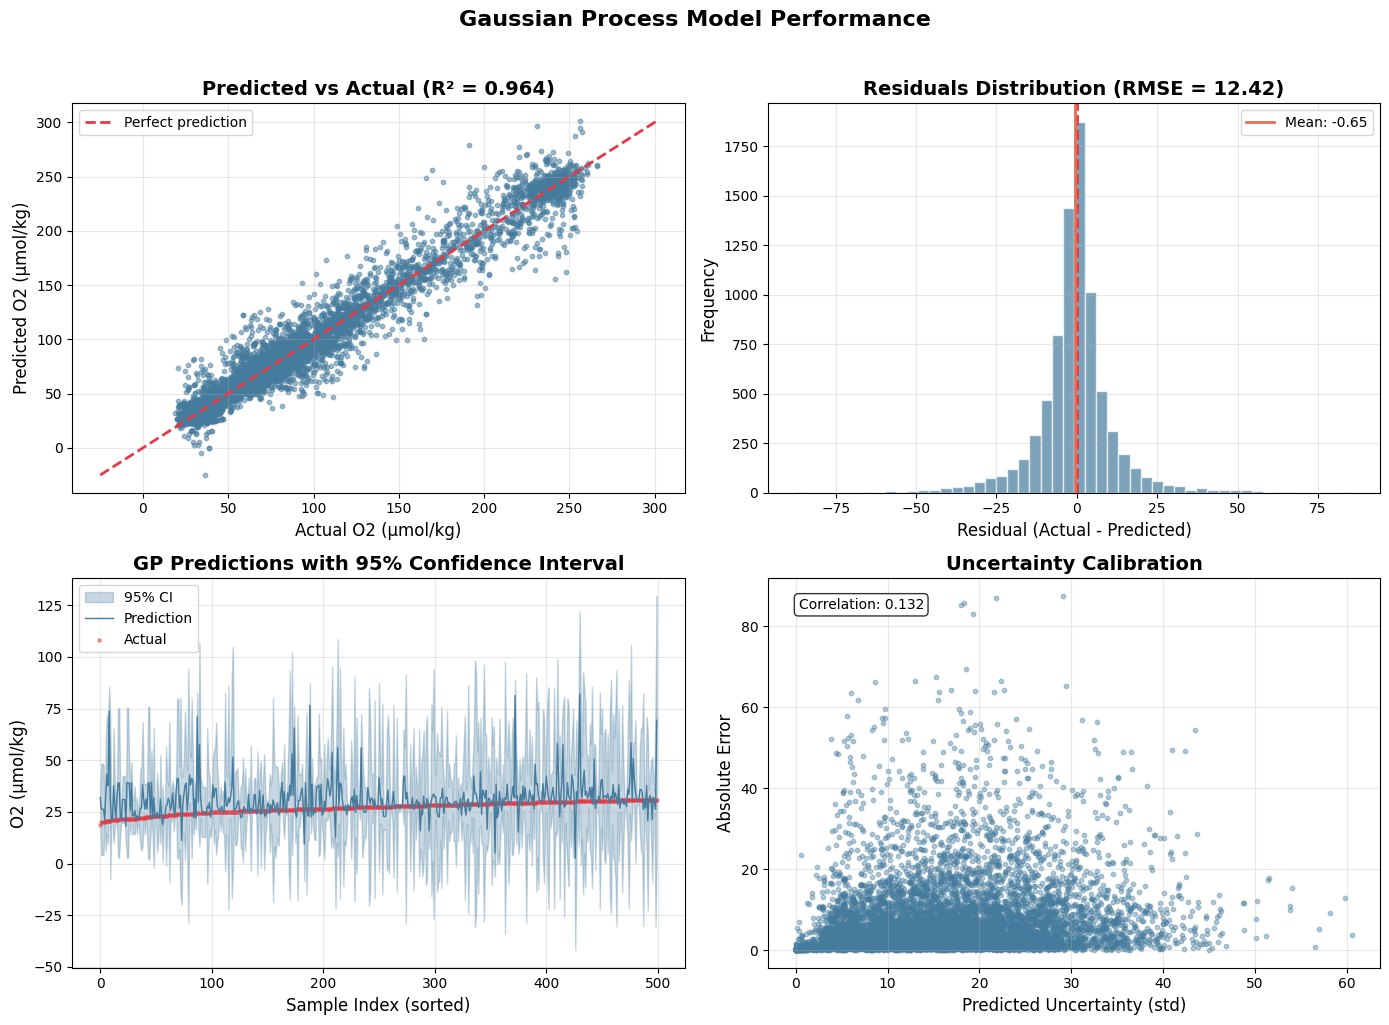

/var/folders/0x/nf7yqth92yz0ljfnq2p9dtc00000gn/T/ipykernel_65581/2805093793.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(PLOT_STYLE['cmap_o2'])(np.linspace(0, 1, len(time_points)))


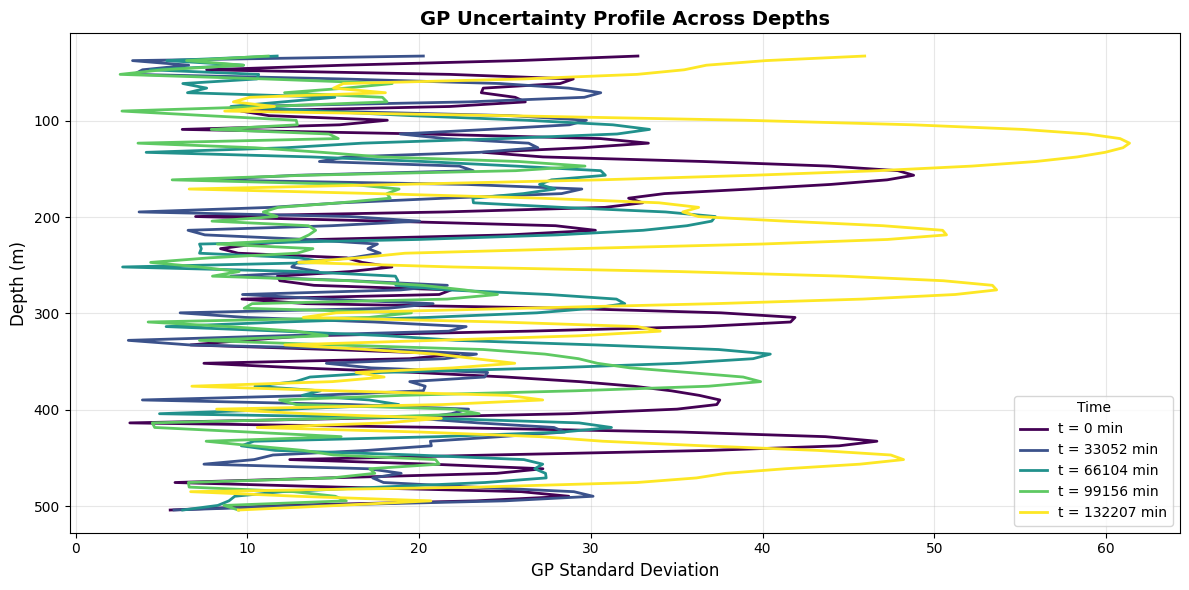

In [7]:
# Visualize GP Model Results
def plot_gp_results(gp_model, save_dir=None):
    """
    Generate comprehensive visualization of GP model performance.
    """
    import os
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Get predictions and ground truth
    y_test = gp_model.y_test
    y_pred = gp_model.prediction_original_scale
    
    # Get uncertainty estimates
    y_mean, y_std, lower, upper = gp_model.measure_uncertainty()
    
    fig, axes = plt.subplots(2, 2, figsize=PLOT_STYLE['fig_multi'])
    
    # Plot 1: Predicted vs Actual
    ax1 = axes[0, 0]
    ax1.scatter(y_test, y_pred, alpha=0.5, s=10, c=PLOT_STYLE['color_bars'])
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], '--', color=PLOT_STYLE['color_samples'], 
             linewidth=2, label='Perfect prediction')
    style_axis(ax1, f'Predicted vs Actual (R² = {r2:.3f})', 'Actual O2 (μmol/kg)', 'Predicted O2 (μmol/kg)')
    ax1.legend(fontsize=PLOT_STYLE['legend_size'])
    
    # Plot 2: Residuals Distribution
    ax2 = axes[0, 1]
    residuals = y_test - y_pred
    ax2.hist(residuals, bins=50, color=PLOT_STYLE['color_bars'], alpha=0.7, edgecolor='white')
    ax2.axvline(x=0, color=PLOT_STYLE['color_samples'], linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color=PLOT_STYLE['color_prediction'], linestyle='-', 
                linewidth=2, label=f'Mean: {residuals.mean():.2f}')
    style_axis(ax2, f'Residuals Distribution (RMSE = {rmse:.2f})', 'Residual (Actual - Predicted)', 'Frequency')
    ax2.legend(fontsize=PLOT_STYLE['legend_size'])
    
    # Plot 3: Prediction with Uncertainty (sorted by actual value)
    ax3 = axes[1, 0]
    sort_idx = np.argsort(y_test)[:500]
    x_plot = np.arange(len(sort_idx))
    ax3.fill_between(x_plot, lower[sort_idx], upper[sort_idx], 
                     alpha=0.3, color=PLOT_STYLE['color_trajectory'], label='95% CI')
    ax3.plot(x_plot, y_mean[sort_idx], '-', color=PLOT_STYLE['color_trajectory'], linewidth=1, label='Prediction')
    ax3.scatter(x_plot, y_test[sort_idx], c=PLOT_STYLE['color_samples'], s=5, alpha=0.5, label='Actual')
    style_axis(ax3, 'GP Predictions with 95% Confidence Interval', 'Sample Index (sorted)', 'O2 (μmol/kg)')
    ax3.legend(fontsize=PLOT_STYLE['legend_size'])
    
    # Plot 4: Uncertainty vs Prediction Error
    ax4 = axes[1, 1]
    abs_error = np.abs(residuals)
    ax4.scatter(y_std, abs_error, alpha=0.4, s=10, c=PLOT_STYLE['color_bars'])
    style_axis(ax4, 'Uncertainty Calibration', 'Predicted Uncertainty (std)', 'Absolute Error')
    
    corr = np.corrcoef(y_std, abs_error)[0, 1]
    ax4.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax4.transAxes, 
             fontsize=PLOT_STYLE['annotation_size'], verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Gaussian Process Model Performance', fontsize=PLOT_STYLE['title_size']+2, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f'{save_dir}/gp_model_results.png', dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()
    
    # Additional plot: GP Variance across depth at different times
    fig2, ax = plt.subplots(figsize=PLOT_STYLE['fig_single'])
    
    time_points = [0, three_month['all_time'].max()/4, 
                   three_month['all_time'].max()/2, 
                   three_month['all_time'].max()*3/4,
                   three_month['all_time'].max()]
    colors = plt.cm.get_cmap(PLOT_STYLE['cmap_o2'])(np.linspace(0, 1, len(time_points)))
    
    sample_depths = np.linspace(three_month['all_depth'].min(), 
                                 three_month['all_depth'].max(), 100)
    
    for t, color in zip(time_points, colors):
        _, variances = gp_model.variance_over_depth(t, sample_depths)
        ax.plot(np.sqrt(variances), sample_depths, color=color, linewidth=2, 
                label=f't = {t:.0f} min')
    
    style_axis(ax, 'GP Uncertainty Profile Across Depths', 
               'GP Standard Deviation', 'Depth (m)', invert_y=True)
    ax.legend(title='Time', loc='lower right', fontsize=PLOT_STYLE['legend_size'])
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(f'{save_dir}/gp_variance_profile.png', dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()

# Generate GP visualization
plot_gp_results(gp_model, save_dir='result graphs')


In [10]:
# Compute depth volatility profile
# Volatility measures temporal variation in O2 predictions at each depth
depth_min = three_month['all_depth'].min()
depth_max = three_month['all_depth'].max()
depth_grid = np.linspace(depth_min, depth_max, 250)   #250 bins

print(f"Depth grid: {depth_min:.1f}m → {depth_max:.1f}m, 50 bins (~{(depth_max-depth_min)/50:.1f}m/bin)")

# Cache for GP variance predictions (improves computational efficiency)
_gp_variance_cache = {}

def gp_variance_at(time_minutes: float, depth_idx: int) -> float:
    """Return GP variance at specified time and depth index with caching."""
    time_key = round(time_minutes, 1)
    cache_key = (time_key, depth_idx)
    
    if cache_key not in _gp_variance_cache:
        depth_val = depth_grid[depth_idx]
        _gp_variance_cache[cache_key] = gp_model.variance_at_point(time_minutes, depth_val)
    
    return _gp_variance_cache[cache_key]

# Sample time grid across 3 months
t_min = three_month['all_time'].min()
t_max = three_month['all_time'].max()
time_grid = np.linspace(t_min, t_max, 30)  # 30 time slices

depth_volatility = np.zeros(len(depth_grid))

for d_idx in range(len(depth_grid)):
    depth_raw = depth_grid[d_idx]
    X_raw = np.column_stack([time_grid, np.full_like(time_grid, depth_raw)])

    # Scale inputs for GP prediction
    X_scaled = X_raw.copy()
    X_scaled[:, 0] = gp_model.scaler_time.transform(X_scaled[:, 0].reshape(-1, 1)).flatten()
    X_scaled[:, 1] = gp_model.scaler_depth.transform(X_scaled[:, 1].reshape(-1, 1)).flatten()

    preds = gp_model.predict(X_scaled)
    depth_volatility[d_idx] = np.std(preds)

# Normalize volatility to [0, 1]
depth_volatility /= depth_volatility.max()

# Report volatility statistics
print(f"Volatility range: {depth_volatility.min():.3f} to {depth_volatility.max():.3f}")
most_volatile_depth_idx = np.argmax(depth_volatility)
most_volatile_depth_m = depth_grid[most_volatile_depth_idx]
print(f"Most volatile depth: {most_volatile_depth_m:.1f}m (index {most_volatile_depth_idx})")
print("All volatility values:")
print(depth_volatility)

Depth grid: 32.8m → 504.1m, 50 bins (~9.4m/bin)
Volatility range: 0.158 to 1.000
Most volatile depth: 66.8m (index 18)
All volatility values:
[0.29595263 0.26227274 0.25300493 0.28270936 0.32481528 0.35646102
 0.3774284  0.41098313 0.46609258 0.53146029 0.59593948 0.65775093
 0.7203649  0.78387818 0.84467747 0.89932563 0.9462125  0.98166541
 1.         0.9968257  0.96906286 0.92640395 0.88483196 0.8433135
 0.79794824 0.75408405 0.72350811 0.70587334 0.69244651 0.68410857
 0.68171928 0.68710276 0.6991677  0.71635906 0.73640636 0.7507634
 0.75426122 0.74867002 0.74250115 0.74073287 0.73613567 0.71722647
 0.68398943 0.64433881 0.60657778 0.58314674 0.57537514 0.5598323
 0.52027728 0.47281199 0.44129899 0.43256278 0.44528314 0.47673365
 0.51846682 0.55645349 0.57814557 0.5798266  0.56709837 0.54887692
 0.53017155 0.51209238 0.49316559 0.47478372 0.46450695 0.4664574
 0.4823337  0.50241518 0.52210835 0.53918514 0.55239747 0.56192691
 0.56602541 0.56216498 0.55064232 0.53660405 0.52372734 0.

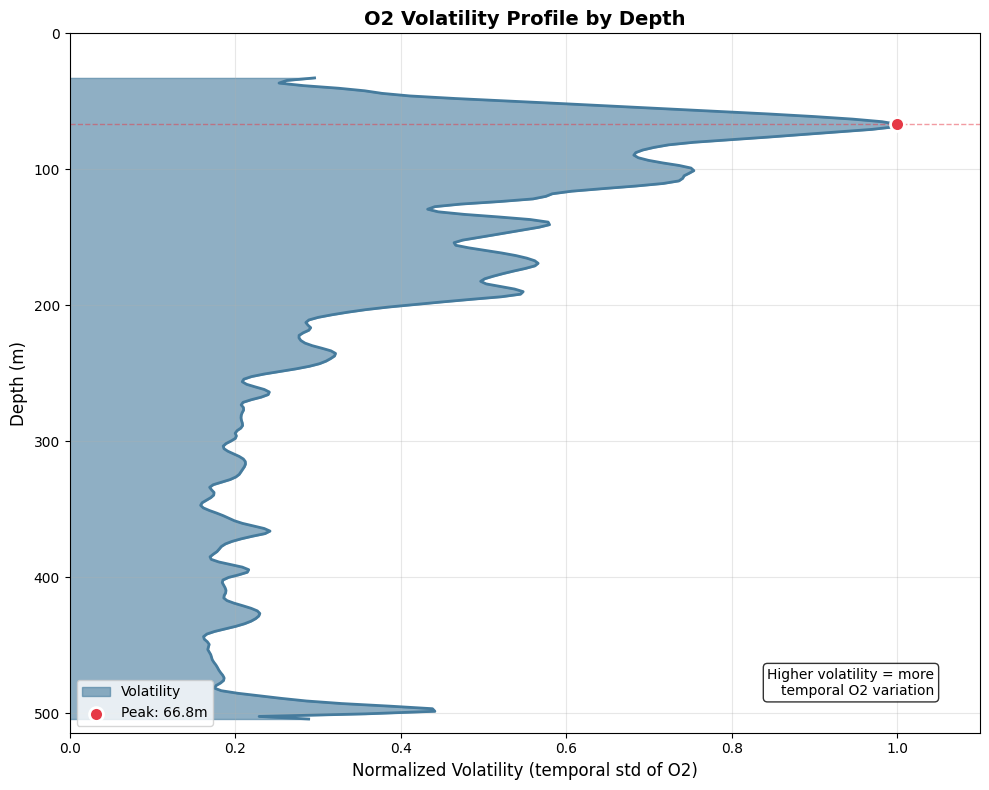

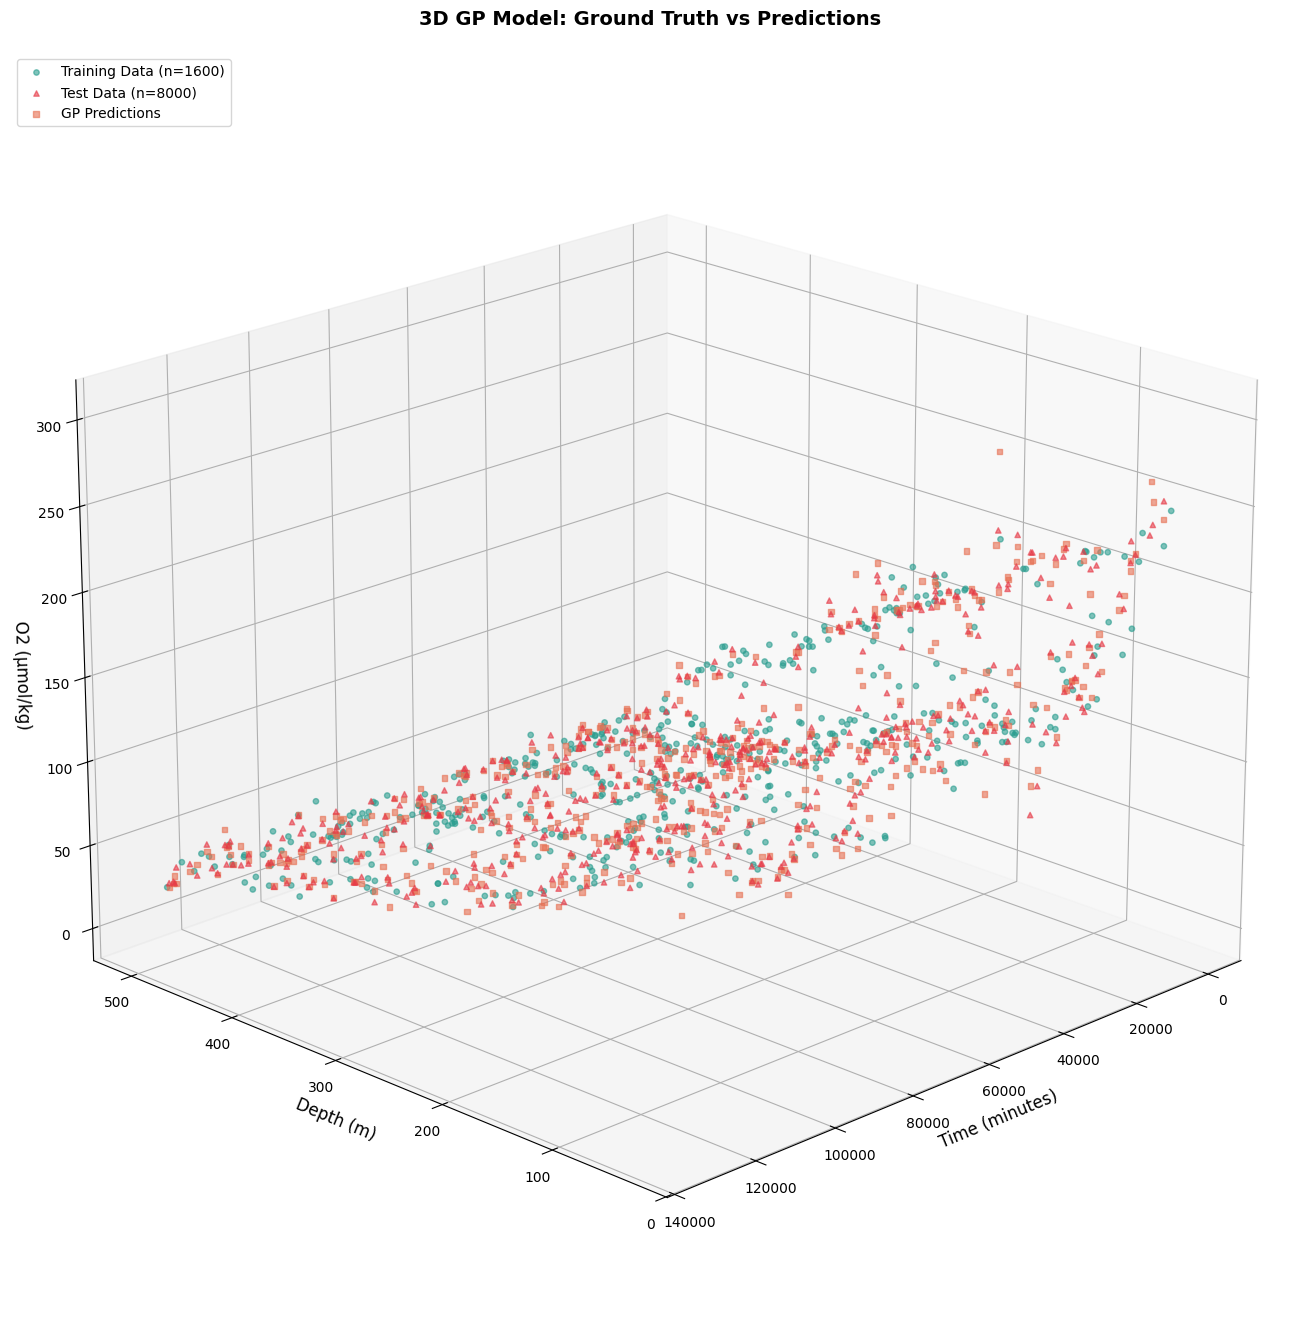

In [26]:
# Visualization: Depth Volatility Profile and 3D GP Visualization
from mpl_toolkits.mplot3d import Axes3D

def plot_depth_volatility(depth_grid, depth_volatility, save_path=None):
    """
    Plot O2 volatility as a function of depth using filled area chart.
    Shows which depths experience more temporal variation in O2 levels.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create horizontal filled area plot (depth on y-axis, volatility on x-axis)
    ax.fill_betweenx(depth_grid, 0, depth_volatility, 
                      alpha=0.6, color=PLOT_STYLE['color_trajectory'],
                      label='Volatility')
    ax.plot(depth_volatility, depth_grid, 
            color=PLOT_STYLE['color_trajectory'], linewidth=2)
    
    # Mark the most volatile depth
    max_idx = np.argmax(depth_volatility)
    ax.scatter([depth_volatility[max_idx]], [depth_grid[max_idx]], 
               s=100, c=PLOT_STYLE['color_samples'], zorder=5,
               edgecolors='white', linewidths=2,
               label=f'Peak: {depth_grid[max_idx]:.1f}m')
    ax.axhline(y=depth_grid[max_idx], color=PLOT_STYLE['color_samples'], 
               linestyle='--', alpha=0.5, linewidth=1)
    
    style_axis(ax, 'O2 Volatility Profile by Depth',
               'Normalized Volatility (temporal std of O2)', 'Depth (m)',
               invert_y=True)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(depth_grid.max() * 1.02,0)  # Extend depth axis to include 0
    ax.legend(loc='lower left', fontsize=PLOT_STYLE['legend_size'])
    
    # Add annotation for interpretation
    ax.text(0.95, 0.05, 
            'Higher volatility = more\ntemporal O2 variation',
            transform=ax.transAxes, fontsize=PLOT_STYLE['annotation_size'],
            ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_gp_3d_visualization(gp_model, save_path=None):
    """
    3D scatter plot showing GP predictions vs ground truth.
    Axes: Time (x), Depth (y), O2 (z)
    Shows training data, test data, and GP predictions.
    """
    fig = plt.figure(figsize=(16, 26))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get raw (unscaled) training data
    train_time = gp_model.scaler_time.inverse_transform(
        gp_model.X_train[:, 0].reshape(-1, 1)).flatten()
    train_depth = gp_model.scaler_depth.inverse_transform(
        gp_model.X_train[:, 1].reshape(-1, 1)).flatten()
    train_o2 = gp_model.y_train_raw  # Raw O2 values
    
    # Get raw (unscaled) test data
    test_time = gp_model.scaler_time.inverse_transform(
        gp_model.X_test[:, 0].reshape(-1, 1)).flatten()
    test_depth = gp_model.scaler_depth.inverse_transform(
        gp_model.X_test[:, 1].reshape(-1, 1)).flatten()
    test_o2 = gp_model.y_test  # Raw O2 values (never scaled)
    
    # Re-run GP predictions on test set (may have been overwritten by other calls)
    pred_o2 = gp_model.predict()  # Defaults to X_test, returns original scale
    
    # Subsample for better visualization (too many points clutters the plot)
    n_train_show = min(500, len(train_time))
    n_test_show = min(500, len(test_time))
    
    train_idx = np.random.choice(len(train_time), n_train_show, replace=False)
    test_idx = np.random.choice(len(test_time), n_test_show, replace=False)
    
    # Plot training data (ground truth)
    ax.scatter(train_time[train_idx], train_depth[train_idx], train_o2[train_idx],
               c=PLOT_STYLE['color_ground_truth'], s=15, alpha=0.6,
               label=f'Training Data (n={len(train_time)})', marker='o')
    
    # Plot test data (ground truth)
    ax.scatter(test_time[test_idx], test_depth[test_idx], test_o2[test_idx],
               c=PLOT_STYLE['color_samples'], s=15, alpha=0.6,
               label=f'Test Data (n={len(test_time)})', marker='^')
    
    # Plot GP predictions for test points
    ax.scatter(test_time[test_idx], test_depth[test_idx], pred_o2[test_idx],
               c=PLOT_STYLE['color_prediction'], s=15, alpha=0.6,
               label='GP Predictions', marker='s')
    
    # Labels and styling
    ax.set_xlabel('Time (minutes)', fontsize=PLOT_STYLE['label_size'], labelpad=5)
    ax.set_ylabel('Depth (m)', fontsize=PLOT_STYLE['label_size'], labelpad=5)
    ax.set_zlabel('O2 (μmol/kg)', fontsize=PLOT_STYLE['label_size'], labelpad=5)
    #ax.zaxis.set_rotate_label(False)  # Keep z-label horizontal for visibility
    ax.set_title('3D GP Model: Ground Truth vs Predictions',
                 fontsize=PLOT_STYLE['title_size'], fontweight='bold', pad=20)
    
    # Invert depth axis (deeper = lower)
    ax.invert_yaxis()
    
    ax.legend(loc='upper left', fontsize=PLOT_STYLE['legend_size'])
    ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    
    # Set viewing angle for better visibility
    ax.view_init(elev=20, azim=45)
    
    # Add extra padding to prevent labels from being cut off
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


# Generate depth volatility visualization
plot_depth_volatility(depth_grid, depth_volatility, 
                      save_path='result graphs/depth_volatility_profile.png')

# Generate 3D GP visualization
plot_gp_3d_visualization(gp_model, save_path='result graphs/gp_3d_visualization.png')


## Planning and Acting

In [122]:
# Priority functions for adaptive sampling
# These functions determine which depths should be sampled based on:
# 1. Time since last visit (temporal weight)
# 2. GP variance at each depth
# 3. Depth volatility (how fast conditions change)
# 4. Visit count (exploration bonus)

def temporal_weight(dt: float, vol: float, base_rate=0.05, max_factor=5.0, min_factor=0.001):
    """
    Compute uncertainty regrowth weight after sampling.
    
    Uncertainty drops immediately after sampling and gradually recovers.
    Higher volatility depths recover faster.
    
    Args:
        dt: Minutes since last sample at this depth (inf if never visited)
        vol: Normalized volatility [0,1] - higher means faster regrowth
        base_rate: Base rate of uncertainty regrowth
        max_factor: Maximum weight for unvisited depths
        min_factor: Minimum weight immediately after sampling
        
    Returns:
        Weight factor in range [min_factor, max_factor]
    """
    dt = max(0.0, dt)
    if np.isinf(dt):
        return max_factor
   
    rate = base_rate * (1.0 + 4.0 * vol)  # vol scales growth 1x-5x faster
    w = min_factor + (max_factor - min_factor) * (1.0 - np.exp(-rate * dt))
    return min(w, max_factor)

def depth_priority(time_minutes: float,
                   depth_idx: int,
                   last_visit_time: np.ndarray,
                   visit_counts: np.ndarray = None,
                   exploration_bonus: float = 100.0) -> float:
    """
    Compute sampling priority for a given depth.
    
    Priority combines GP variance, depth volatility, and temporal weight.
    Unvisited depths receive high priority to ensure initial coverage.
    Recently sampled depths have low priority that gradually recovers.
    
    Args:
        time_minutes: Current time in minutes
        depth_idx: Index into depth_grid
        last_visit_time: Array of last visit times for each depth
        visit_counts: Array of visit counts for each depth
        exploration_bonus: Bonus for exploration (unused in current implementation)
        
    Returns:
        Priority value (higher = more important to sample)
    """
    var = gp_variance_at(time_minutes, depth_idx)
    vol = depth_volatility[depth_idx]
    dt = time_minutes - last_visit_time[depth_idx]
    w_time = temporal_weight(dt, vol)
    base_priority = var * vol * w_time
    
    # Priority hierarchy based on visit count
    if visit_counts is not None:
        visit_count = visit_counts[depth_idx]
        if visit_count == 0:
            # Unvisited depths get flat high priority
            return 10000.0
        elif visit_count == 1:
            return base_priority * 1.5
        elif visit_count == 2:
            return base_priority * 1.2
        else:
            return base_priority
    else:
        if np.isinf(dt):
            return 10000.0
        return base_priority


print("Priority functions initialized")

Priority functions initialized


In [124]:
# Markov Decision Process for adaptive sampling
# The MDP models the profiler's decision problem: at each state (depth, time),
# choose which depth to sample next to maximize information gain.

HORIZON_STEPS = len(three_month)

class Action(Enum):
    STAY = 0
    MOVE_UP = 1
    MOVE_DOWN = 2

# Robot physical parameters
ROBOT_SPEED_M_PER_MIN = 10.0  # Vertical travel speed (m/min)
DEPTH_STEP = float(depth_grid[1] - depth_grid[0])  # Grid resolution (m)
TRAVEL_TIME_PER_STEP = DEPTH_STEP / ROBOT_SPEED_M_PER_MIN
SAMPLE_TIME = 0.5  # Time to collect one sample (minutes)


class MDP:
    """
    Markov Decision Process for the adaptive sampling problem.
    
    State: (depth_idx, time_step)
    Action: STAY, MOVE_UP, MOVE_DOWN (greedy selection of best reachable depth)
    Reward: Based on sampling priority at destination
    """
    
    def __init__(self, last_visit_time: np.ndarray, visit_counts: np.ndarray = None):
        self.last_visit_time = last_visit_time
        if visit_counts is None:
            self.visit_counts = np.zeros(len(depth_grid), dtype=int)
        else:
            self.visit_counts = visit_counts

    def is_terminal(self, state: State) -> bool:
        return state.time_step >= HORIZON_STEPS - 1

    
    def successors(self, state: State, action: Action):
        cur_depth = state.depth_idx
        cur_step = state.time_step
        t_cur = float(three_month.iloc[min(cur_step, len(three_month)-1)]['all_time'])
        
        # Physical constraint: maximum travel distance per time step
        MAX_TRAVEL_MINUTES = 4.0
        max_travel_m = ROBOT_SPEED_M_PER_MIN * MAX_TRAVEL_MINUTES
        
        best_reward = -np.inf
        best_depth = cur_depth
        best_time = cur_step
        
        # Search ALL locations within travel budget
        for candidate_depth in range(len(depth_grid)):
            travel_dist = abs(depth_grid[candidate_depth] - depth_grid[cur_depth])
            
            if travel_dist > max_travel_m:
                continue
                
            travel_time = travel_dist / ROBOT_SPEED_M_PER_MIN
            total_time = travel_time + SAMPLE_TIME
            
            # Map to real dataset time
            t_next = t_cur + total_time
            idx_next = int(np.searchsorted(three_month['all_time'].values, t_next))
            idx_next = min(idx_next, HORIZON_STEPS - 1)
            t_next_val = float(three_month.iloc[idx_next]['all_time'])
            
            # Get visit count for this candidate
            candidate_visits = self.visit_counts[candidate_depth]
            
            # Base importance from priority function
            importance = depth_priority(t_next_val, candidate_depth, self.last_visit_time, 
                                    self.visit_counts, exploration_bonus=100.0)
            
            # Distance bonus for unvisited depths encourages spatial coverage
            if candidate_visits == 0:
                distance_bonus = travel_dist * 20.0
            else:
                distance_bonus = 0
            
            movement_cost = -0.1 * travel_dist
            move_bonus = 250 if candidate_depth != cur_depth else 0

            reward = importance + distance_bonus + movement_cost + move_bonus
            
            if reward > best_reward:
                best_reward = reward
                best_depth = candidate_depth
                best_time = idx_next
        
        next_state = State(best_depth, best_time)
        return [(next_state, 1.0, best_reward)]


In [125]:
@dataclass(frozen=True)
class State:
    """Immutable state representation for Planner."""
    depth_idx: int
    time_step: int


class RTDPPlanner:
    """
    Real-Time Dynamic Programming planner for adaptive sampling.
    
    RTDP performs online planning by simulating trajectories and
    backing up value estimates along the way.
    """
    
    def __init__(self, mdp: MDP):
        self.mdp = mdp
        self.V: Dict[State, float] = {}
        self.policy: Dict[State, Action] = {}
        self.visits: Dict[State, int] = {}
        
    def clear_cache(self, clear_v_values: bool = False):
        """Clear cached policy and optionally value estimates."""
        self.policy.clear()
        
        if clear_v_values:
            # Clear value estimates for frequently visited depths
            states_to_clear = []
            for state in list(self.V.keys()):
                if (state.depth_idx < len(self.mdp.visit_counts) and 
                    self.mdp.visit_counts[state.depth_idx] >= 4):
                    states_to_clear.append(state)
            for state in states_to_clear:
                del self.V[state]

   
    def heuristic(self, state: State) -> float:
        """Estimate future value using lookahead on priority function."""
        t_val = float(three_month.iloc[min(state.time_step, len(three_month)-1)]['all_time'])
        
        # Lookahead heuristic: sum priorities over future time steps
        total_h = 0.0
        for lookahead in range(4):
            t_future = float(three_month.iloc[min(state.time_step + lookahead*3, len(three_month)-1)]['all_time'])
            total_h += depth_priority(t_future, state.depth_idx, self.mdp.last_visit_time, self.mdp.visit_counts)
        return total_h * 0.3 #choose scale factor

    def backup(self, state: State):
        """Perform Bellman backup at the given state."""
        if state in self.V:
            return
            
        self.visits[state] = self.visits.get(state, 0) + 1
        
        if self.mdp.is_terminal(state):
            self.V[state] = 0.0
            return

        # Compute successors once (greedy MDP returns same result for all actions)
        succs = self.mdp.successors(state, Action.STAY)
        if not succs:
            self.V[state] = -1e3
            self.policy[state] = Action.STAY
            return
            
        next_s, _, rew = succs[0]
        v_next = self.heuristic(next_s)
        
        # Select action that best matches the target direction
        cur_depth = state.depth_idx
        target_depth = next_s.depth_idx
        depth_change = depth_grid[target_depth] - depth_grid[cur_depth]
        
        qvalues = {}
        for action in Action:
            if action == Action.STAY:
                direction_penalty = 1000 if abs(depth_change) > DEPTH_STEP else 0
            elif action == Action.MOVE_UP:
                direction_penalty = max(0, 3 * depth_change)
            else:  # MOVE_DOWN
                direction_penalty = max(0, 3 * (-depth_change))
                
            qvalues[action] = rew + 0.95 * v_next - direction_penalty

        best_action = max(qvalues, key=qvalues.get)
        self.V[state] = qvalues[best_action]
        self.policy[state] = best_action


    def simulate(self, start_state: State, n_rollouts: int = 20):
        """Perform RTDP simulation rollouts to update value estimates."""
        for _ in range(n_rollouts):
            state = State(start_state.depth_idx, start_state.time_step)
            for step in range(50):
                if self.mdp.is_terminal(state):
                    break
                self.backup(state)
                action = self.policy.get(state, Action.STAY)
                succs = self.mdp.successors(state, action)
                if not succs:
                    break
                state = succs[0][0]

    def greedy_action(self, state: State) -> Action:
        """Select the best action for the current state with fresh value computation."""
        # Clear cached values to ensure fresh computation with updated visit counts
        if state in self.V:
            del self.V[state]
        if state in self.policy:
            del self.policy[state]
        
        self.backup(state)
        
        if state in self.policy:
            return self.policy[state]
        
        return Action.STAY



In [126]:
def run_sampling_plan(sample_budget: int, start_depth_idx: int = 49):
    """
    Execute the adaptive sampling plan using RTDP.
    
    Args:
        sample_budget: Maximum number of samples to collect
        start_depth_idx: Initial depth index for the profiler
        
    Returns:
        DataFrame containing the sampling trajectory
    """
    # Initialize state tracking arrays
    last_visit_time = np.full(len(depth_grid), -np.inf)
    visit_counts = np.zeros(len(depth_grid), dtype=int)

    # Initialize MDP and planner
    mdp = MDP(last_visit_time, visit_counts)
    planner = RTDPPlanner(mdp)
    planner.simulate(State(6, 0), n_rollouts=20)

    state = State(start_depth_idx, 0)
    samples = []
    steps_taken = 0
    max_steps = HORIZON_STEPS

    while len(samples) < sample_budget and not mdp.is_terminal(state) and steps_taken < max_steps:
        # Plan and select action
        planner.simulate(state, n_rollouts=20)
        action = planner.greedy_action(state)

        # Execute action
        succs = mdp.successors(state, action)
        if not succs:
            break
        next_state, _, _ = succs[0]

        # Record sample and update visit tracking
        t_idx = min(next_state.time_step, len(three_month) - 1)
        t_val = float(three_month.iloc[t_idx]['all_time'])
        last_visit_time[next_state.depth_idx] = t_val
        visit_counts[next_state.depth_idx] += 1
        
        # Synchronize MDP state
        mdp.last_visit_time = last_visit_time
        mdp.visit_counts = visit_counts
        
        # Clear stale cache entries
        should_clear_v = visit_counts[next_state.depth_idx] >= 2
        planner.clear_cache(clear_v_values=should_clear_v)

        # Store sample data
        samples.append({
            'time_idx': next_state.time_step,
            'time_minutes': t_val,
            'depth_idx': next_state.depth_idx,
            'depth_m': float(depth_grid[next_state.depth_idx])
        })
        planner.simulate(next_state, n_rollouts=10)

        state = next_state
        steps_taken += 1
        
        if len(samples) % 10 == 0:
            print(f"  Progress: {len(samples)}/{sample_budget} samples")

    return pd.DataFrame(samples)

## One-off Testing Results and Visualizations

In [127]:
# Execute sampling mission
results = {}
budget = 500
print(f"\nExecuting {budget}-sample mission...")
plan_df = run_sampling_plan(budget)
results[budget] = plan_df
print(f"Completed: {len(plan_df)} samples collected")
print(f"  Time span: {plan_df['time_minutes'].min():.0f} to {plan_df['time_minutes'].max():.0f} min")
print(f"  Depth span: {plan_df['depth_m'].min():.0f} to {plan_df['depth_m'].max():.0f} m")



Executing 500-sample mission...
  Progress: 10/500 samples
  Progress: 20/500 samples
  Progress: 30/500 samples
  Progress: 40/500 samples
  Progress: 50/500 samples
  Progress: 60/500 samples
  Progress: 70/500 samples
  Progress: 80/500 samples
  Progress: 90/500 samples
  Progress: 100/500 samples
  Progress: 110/500 samples
  Progress: 120/500 samples
  Progress: 130/500 samples
  Progress: 140/500 samples
  Progress: 150/500 samples
  Progress: 160/500 samples
  Progress: 170/500 samples
  Progress: 180/500 samples
  Progress: 190/500 samples
  Progress: 200/500 samples
  Progress: 210/500 samples
  Progress: 220/500 samples
  Progress: 230/500 samples
  Progress: 240/500 samples
  Progress: 250/500 samples
  Progress: 260/500 samples
  Progress: 270/500 samples
  Progress: 280/500 samples
  Progress: 290/500 samples
  Progress: 300/500 samples
  Progress: 310/500 samples
  Progress: 320/500 samples
  Progress: 330/500 samples
  Progress: 340/500 samples
  Progress: 350/500 samp

Sampling trajectory for 500-sample mission:



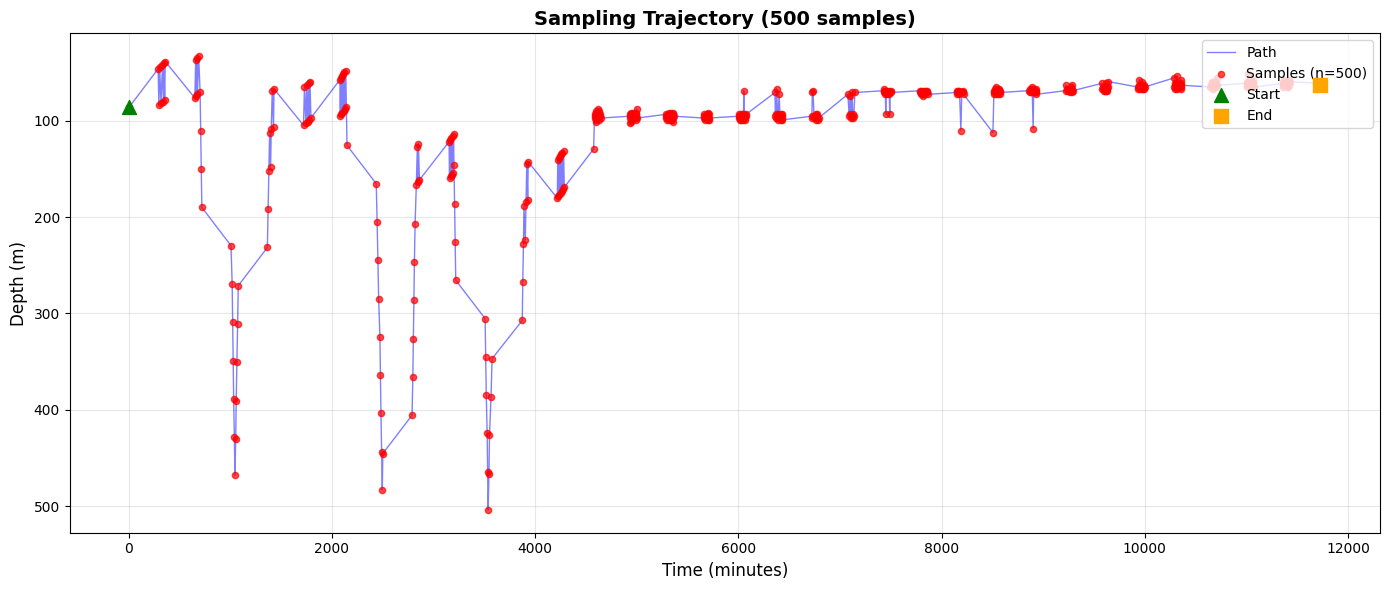


Sampling Statistics:
  Total samples: 500
  Time range: 6.4 - 11728.4 minutes
  Depth range: 32.8 - 504.1 m
  Unique depths visited: 129
  Depth coverage: 51.6%
  Adaptive sampling rate: 5.00% of total data


In [139]:
# Plot sampled locations from run_sampling_plan
def plot_sampling_locations(plan_df, title_suffix=""):
    """
    Visualize the sampling trajectory: Time vs Depth
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot the sampling path (trajectory)
    ax.plot(plan_df['time_minutes'], plan_df['depth_m'], 
            'b-', alpha=0.5, linewidth=1, label='Path')
    
    # Plot sample points
    ax.scatter(plan_df['time_minutes'], plan_df['depth_m'], 
               c='red', s=20, alpha=0.7, zorder=5, label=f'Samples (n={len(plan_df)})')
    
    # Mark start and end
    ax.scatter(plan_df['time_minutes'].iloc[0], plan_df['depth_m'].iloc[0], 
               c='green', s=100, marker='^', zorder=10, label='Start')
    ax.scatter(plan_df['time_minutes'].iloc[-1], plan_df['depth_m'].iloc[-1], 
               c='orange', s=100, marker='s', zorder=10, label='End')
    
    ax.set_xlabel('Time (minutes)', fontsize=12)
    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.set_title(f'Sampling Trajectory{title_suffix}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Depth increases downward
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nSampling Statistics:")
    print(f"  Total samples: {len(plan_df)}")
    print(f"  Time range: {plan_df['time_minutes'].min():.1f} - {plan_df['time_minutes'].max():.1f} minutes")
    print(f"  Depth range: {plan_df['depth_m'].min():.1f} - {plan_df['depth_m'].max():.1f} m")
    print(f"  Unique depths visited: {plan_df['depth_m'].nunique()}")
    print(f"  Depth coverage: {plan_df['depth_m'].nunique() / len(depth_grid) * 100:.1f}%")
    print(f"  Adaptive sampling rate: {len(plan_df) / len(three_month) * 100:.2f}% of total data")

# Visualize results
if 'results' in globals() and len(results) > 0:
    budget = list(results.keys())[0]
    plan_df = results[budget]
    print(f"Sampling trajectory for {budget}-sample mission:\n")
    plot_sampling_locations(plan_df, title_suffix=f" ({budget} samples)")
else:
    print("No results available. Run run_sampling_plan() first.")


## Result Evaluations

In [31]:
# Reconstruction accuracy evaluation
# Measures how well the sampled depth profile matches the actual O2 distribution

def reconstruction_accuracy(plan_df, verbose=True):
    """
    Evaluate reconstruction accuracy for vertical profiling.
    
    Method:
    1. Build a depth profile from the latest O2 measurement at each sampled depth
    2. Interpolate along the depth axis to create a continuous profile
    3. Compare to the actual O2 profile from the corresponding time in the dataset
    
    Args:
        plan_df: DataFrame with sampling plan (time_minutes, depth_m columns)
        verbose: Print detailed output
        
    Returns:
        R-squared value as percentage (0-100)
    """
    # Build depth profile: keep LATEST measurement at each unique depth
    latest_by_depth = {}
    for _, row in plan_df.iterrows():
        depth = row['depth_m']
        time = row['time_minutes']
        
        # Get actual O2 value from dataset at this sample location
        dist = np.sqrt((three_month['all_time'] - time)**2 + 
                      (three_month['all_depth'] - depth)**2)
        nearest_idx = dist.idxmin()
        o2_val = three_month.loc[nearest_idx, 'all_o2']
        
        # Keep only the latest sample at each depth
        if depth not in latest_by_depth or time > latest_by_depth[depth]['time']:
            latest_by_depth[depth] = {'time': time, 'o2': o2_val}
    
    # Extract our reconstructed depth profile
    profile_depths = np.array(sorted(latest_by_depth.keys()))
    profile_o2 = np.array([latest_by_depth[d]['o2'] for d in profile_depths])
    
    if verbose:
        print(f"Depth profile: {len(profile_depths)} unique depths")
        print(f"  Range: {profile_depths.min():.1f}m - {profile_depths.max():.1f}m")
    
    # Get ground truth: the LATEST time chunk from original data
    max_sample_time = plan_df['time_minutes'].max()
    time_window = 60.0  # Look at last 60 minutes of data
    
    latest_data = three_month[
        (three_month['all_time'] >= max_sample_time - time_window) &
        (three_month['all_time'] <= max_sample_time + time_window) &
        (three_month['all_depth'] >= profile_depths.min()) &
        (three_month['all_depth'] <= profile_depths.max())
    ].copy()
    
    # If no data in that window, expand the search
    if len(latest_data) < 10:
        latest_data = three_month[
            (three_month['all_depth'] >= profile_depths.min()) &
            (three_month['all_depth'] <= profile_depths.max())
        ].copy()
        # Get the last N points by time
        latest_data = latest_data.nlargest(500, 'all_time')
    
    if len(latest_data) == 0:
        print("Warning: No ground truth data found")
        return 0.0
    
    if verbose:
        print(f"  Ground truth: {len(latest_data)} points")
    
    # Create 1D interpolator from depth profile
    if len(profile_depths) < 2:
        print("Warning: Need at least 2 depths for interpolation")
        return 0.0
    
    interpolator = interp1d(
        profile_depths, profile_o2, 
        kind='linear', 
        bounds_error=False, 
        fill_value=(profile_o2[0], profile_o2[-1])  # Extrapolate edges
    )
    
    # Compare interpolated profile to ground truth
    test_depths = latest_data['all_depth'].values
    y_true = latest_data['all_o2'].values
    y_interp = interpolator(test_depths)
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_interp)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_interp)
    mae = np.mean(np.abs(y_true - y_interp))
    
    if verbose:
        print(f"\nReconstruction Results:")
        print(f"  MSE:  {mse:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAE:  {mae:.2f}")
        print(f"  R2:   {r2:.4f} ({r2*100:.1f}%)")
    
    return r2 * 100


In [ ]:
# Evaluate reconstruction accuracy
if 'results' in globals() and len(results) > 0:
    budget = list(results.keys())[0]
    plan_df = results[budget]
    print(f"Evaluating reconstruction accuracy for {budget}-sample plan...\n")
    accuracy = reconstruction_accuracy(plan_df)
    print(f"\nResult: {accuracy:.1f}% reconstruction accuracy with {budget} samples")



Evaluating reconstruction accuracy for 500-sample plan...

Depth profile: 129 unique depths
  Range: 32.8m - 504.1m
  Ground truth: 31 points

Reconstruction Results:
  MSE:  799.52
  RMSE: 28.28
  MAE:  17.57
  R2:   0.7151 (71.5%)

Result: 71.5% reconstruction accuracy with 500 samples


In [32]:
# Correlation analysis between sampling frequency and variance
# Tests whether the adaptive strategy prioritizes high-uncertainty regions

def analyze_sampling_vs_variance(plan_df, verbose=True):
    """
    Analyze correlation between sampling frequency and GP variance/volatility.
    
    Args:
        plan_df: DataFrame with sampling plan
        verbose: Print detailed analysis
        
    Returns:
        Dictionary with Spearman correlation coefficients
    """
    # 1. Count samples per depth bin
    sample_depths = plan_df['depth_m'].values
    
    # Map each sample to nearest depth_grid index
    sample_counts = np.zeros(len(depth_grid))
    for d in sample_depths:
        idx = np.argmin(np.abs(depth_grid - d))
        sample_counts[idx] += 1
    
    # 2. Get variance at each depth (use middle of time range)
    mid_time = plan_df['time_minutes'].median()
    variances = np.array([gp_variance_at(mid_time, i) for i in range(len(depth_grid))])
    
    # 3. Get volatility at each depth
    volatilities = depth_volatility
    
    # 4. Calculate correlations (on all depths)
    pearson_var, p_var = pearsonr(sample_counts, variances)
    spearman_var, sp_var = spearmanr(sample_counts, variances)
    pearson_vol, p_vol = pearsonr(sample_counts, volatilities)
    spearman_vol, sp_vol = spearmanr(sample_counts, volatilities)
    
    sampled_mask = sample_counts > 0
    
    if verbose:
        print("SAMPLING vs VARIANCE ANALYSIS")
        print("=" * 50)
        print(f"\nSampling Distribution:")
        print(f"  Total samples: {int(sample_counts.sum())}")
        print(f"  Unique depths sampled: {sampled_mask.sum()} / {len(depth_grid)}")
        print(f"  Max samples at one depth: {int(sample_counts.max())}")
        
        print(f"\nCorrelation with GP Variance:")
        print(f"  Pearson r:  {pearson_var:.3f} (p={p_var:.4f})")
        print(f"  Spearman rho: {spearman_var:.3f} (p={sp_var:.4f})")
        
        print(f"\nCorrelation with Volatility:")
        print(f"  Pearson r:  {pearson_vol:.3f} (p={p_vol:.4f})")
        print(f"  Spearman rho: {spearman_vol:.3f} (p={sp_vol:.4f})")
        # Top sampled vs top variance depths
        top_sampled_idx = np.argsort(sample_counts)[-5:][::-1]
        top_variance_idx = np.argsort(variances)[-5:][::-1]
        
        print(f"\nTop 5 Most Sampled Depths:")
        for idx in top_sampled_idx:
            if sample_counts[idx] > 0:
                print(f"  {depth_grid[idx]:.1f}m: {int(sample_counts[idx])} samples, var={variances[idx]:.1f}, vol={volatilities[idx]:.2f}")
        
        print(f"\nTop 5 Highest Variance Depths:")
        for idx in top_variance_idx:
            print(f"  {depth_grid[idx]:.1f}m: {int(sample_counts[idx])} samples, var={variances[idx]:.1f}, vol={volatilities[idx]:.2f}")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Sample counts vs depth
    ax1 = axes[0]
    ax1.barh(depth_grid, sample_counts, height=depth_grid[1]-depth_grid[0], alpha=0.7)
    ax1.set_ylabel('Depth (m)')
    ax1.set_xlabel('Sample Count')
    ax1.set_title('Samples per Depth')
    ax1.invert_yaxis()
    
    # Plot 2: Variance vs depth  
    ax2 = axes[1]
    ax2.plot(variances, depth_grid, 'r-', linewidth=2, label='GP Variance')
    ax2.plot(volatilities * variances.max(), depth_grid, 'b--', linewidth=1, label='Volatility (scaled)')
    ax2.set_ylabel('Depth (m)')
    ax2.set_xlabel('Variance')
    ax2.set_title('Variance Profile')
    ax2.legend()
    ax2.invert_yaxis()
    
    # Plot 3: Scatter - samples vs variance
    ax3 = axes[2]
    ax3.scatter(variances[sampled_mask], sample_counts[sampled_mask], alpha=0.6, s=50)
    ax3.set_xlabel('GP Variance')
    ax3.set_ylabel('Sample Count')
    ax3.set_title(f'Samples vs Variance (ρ={spearman_var:.2f})')
    
    plt.tight_layout()
    plt.show()
    
    return {'spearman_variance': spearman_var, 'spearman_volatility': spearman_vol}

# Run correlation analysis
if 'results' in globals() and len(results) > 0:
    budget = list(results.keys())[0]
    plan_df = results[budget]
    print(f"Analyzing {budget}-sample plan...\n")
    stats = analyze_sampling_vs_variance(plan_df)
else:
    print("No results available. Run run_sampling_plan() first.")


No results available. Run run_sampling_plan() first.


## Automated Experiments
Generate sampling plans, compute metrics, and visualize results across multiple sample budgets for systematic evaluation.

In [28]:
# BASELINE SAMPLING STRATEGIES

def uniform_sampling_plan(sample_budget: int, seed: int = 42):
    """
    Uniform sampling: evenly distributed samples across time and depth.
    Creates a grid pattern that covers the full range.
    
    Args:
        sample_budget: Number of samples to collect
        seed: Random seed for reproducibility
        
    Returns:
        DataFrame with uniform sampling plan
    """
    np.random.seed(seed)
    
    # Determine grid dimensions (approximately square coverage)
    n_time_bins = int(np.sqrt(sample_budget * 2))  # More time points
    n_depth_bins = sample_budget // n_time_bins
    
    # Create uniform grids
    time_min, time_max = three_month['all_time'].min(), three_month['all_time'].max()
    depth_min, depth_max = three_month['all_depth'].min(), three_month['all_depth'].max()
    
    time_points = np.linspace(time_min, time_max, n_time_bins)
    depth_points = np.linspace(depth_min, depth_max, n_depth_bins)
    
    # Create all combinations
    samples = []
    for t in time_points:
        for d in depth_points:
            if len(samples) >= sample_budget:
                break
            # Find nearest time index
            time_idx = np.searchsorted(three_month['all_time'].values, t)
            time_idx = min(time_idx, len(three_month) - 1)
            
            # Find nearest depth index
            depth_idx = np.argmin(np.abs(depth_grid - d))
            
            samples.append({
                'time_idx': time_idx,
                'time_minutes': t,
                'depth_idx': depth_idx,
                'depth_m': depth_grid[depth_idx]
            })
        if len(samples) >= sample_budget:
            break
    
    # If we still need more samples, add them at random positions
    while len(samples) < sample_budget:
        t = np.random.uniform(time_min, time_max)
        d = np.random.uniform(depth_min, depth_max)
        time_idx = np.searchsorted(three_month['all_time'].values, t)
        time_idx = min(time_idx, len(three_month) - 1)
        depth_idx = np.argmin(np.abs(depth_grid - d))
        
        samples.append({
            'time_idx': time_idx,
            'time_minutes': t,
            'depth_idx': depth_idx,
            'depth_m': depth_grid[depth_idx]
        })
    
    return pd.DataFrame(samples[:sample_budget])


def random_sampling_plan(sample_budget: int, seed: int = 42):
    """
    Random sampling: randomly selected samples from the dataset.
    
    Args:
        sample_budget: Number of samples to collect
        seed: Random seed for reproducibility
        
    Returns:
        DataFrame with random sampling plan
    """
    np.random.seed(seed)
    
    # Randomly select indices from the dataset
    random_indices = np.random.choice(len(three_month), size=sample_budget, replace=False)
    random_indices = np.sort(random_indices)  # Sort by time for trajectory visualization
    
    samples = []
    for idx in random_indices:
        row = three_month.iloc[idx]
        depth_idx = np.argmin(np.abs(depth_grid - row['all_depth']))
        
        samples.append({
            'time_idx': idx,
            'time_minutes': row['all_time'],
            'depth_idx': depth_idx,
            'depth_m': depth_grid[depth_idx]
        })
    
    return pd.DataFrame(samples)


def generate_baseline_plans(budgets=[250, 500, 1000, 2000, 5000], save_path=None):
    """
    Generate uniform and random sampling plans for all budgets.
    
    Args:
        budgets: List of sample budgets to test
        save_path: Optional path to save plans
        
    Returns:
        dict: {'uniform': {budget: plan_df}, 'random': {budget: plan_df}}
    """
    all_baselines = {'uniform': {}, 'random': {}}
    
    print("GENERATING BASELINE SAMPLING PLANS")
    print("=" * 60)
    
    for budget in budgets:
        print(f"\nBudget: {budget} samples")
        
        # Uniform sampling
        uniform_plan = uniform_sampling_plan(budget)
        all_baselines['uniform'][budget] = uniform_plan
        print(f"  Uniform: {len(uniform_plan)} samples, {uniform_plan['depth_m'].nunique()} unique depths")
        
        # Random sampling
        random_plan = random_sampling_plan(budget)
        all_baselines['random'][budget] = random_plan
        print(f"  Random:  {len(random_plan)} samples, {random_plan['depth_m'].nunique()} unique depths")
    
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(all_baselines, f)
        print(f"\nBaseline plans saved to: {save_path}")
    
    return all_baselines


def compute_baseline_metrics(baseline_plans):
    """
    Compute metrics for all baseline plans.
    
    Args:
        baseline_plans: dict from generate_baseline_plans()
        
    Returns:
        DataFrame with metrics for each method and budget
    """
    all_results = []
    
    print("COMPUTING BASELINE METRICS")
    print("=" * 60)
    
    for method, plans in baseline_plans.items():
        print(f"\n{method.upper()} sampling:")
        for budget, plan_df in sorted(plans.items()):
            print(f"  Processing budget={budget}...")
            
            accuracy = reconstruction_accuracy(plan_df, verbose=False)
            unique_depths = plan_df['depth_m'].nunique()
            depth_coverage = unique_depths / len(depth_grid) * 100
            time_span = plan_df['time_minutes'].max() - plan_df['time_minutes'].min()
            corr_variance, corr_volatility = get_variance_correlation(plan_df)
            
            result = {
                'method': method,
                'budget': budget,
                'actual_samples': len(plan_df),
                'accuracy_r2': accuracy,
                'unique_depths': unique_depths,
                'depth_coverage_pct': depth_coverage,
                'time_span_min': time_span,
                'corr_variance': corr_variance,
                'corr_volatility': corr_volatility
            }
            all_results.append(result)
    
    return pd.DataFrame(all_results)



In [ ]:
# Plan Generation
def generate_plans(budgets=[250, 500, 1000, 2000, 5000], start_depth_idx=49, save_path=None):
    """
    Run sampling plans for each budget. Save raw plans for later analysis.
    
    Args:
        budgets: List of sample budgets to test
        start_depth_idx: Starting depth index
        save_path: Optional path to save plans (e.g., 'plans.pkl')
    
    Returns:
        dict: {budget: plan_df} for each budget
    """
    import time
    
    all_plans = {}
    
    print("GENERATING SAMPLING PLANS")
    print("=" * 60)
    print(f"Budgets: {budgets}")
    print("=" * 60)
    
    for budget in budgets:
        print(f"\nBudget: {budget} samples...")
        start_time = time.time()
        
        plan_df = run_sampling_plan(budget, start_depth_idx=start_depth_idx)        
        all_plans[budget] = plan_df
        print(f"  Completed: {len(plan_df)}")
    
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(all_plans, f)
        print(f"\nPlans saved to: {save_path}")
    
    print(f"\nGenerated {len(all_plans)} plans")
    return all_plans
    


In [147]:
#Generate and save sampling plans
budgets_to_test = [250, 500, 1000, 2000, 5000]

print("Generating sampling plans...")
all_plans = generate_plans(
    budgets=budgets_to_test, 
    save_path='sampling_plans.pkl'
)


Generating sampling plans...
GENERATING SAMPLING PLANS
Budgets: [250, 500, 1000, 2000, 5000]

Budget: 250 samples...
  Progress: 10/250 samples
  Progress: 20/250 samples
  Progress: 30/250 samples
  Progress: 40/250 samples
  Progress: 50/250 samples
  Progress: 60/250 samples
  Progress: 70/250 samples
  Progress: 80/250 samples
  Progress: 90/250 samples
  Progress: 100/250 samples
  Progress: 110/250 samples
  Progress: 120/250 samples
  Progress: 130/250 samples
  Progress: 140/250 samples
  Progress: 150/250 samples
  Progress: 160/250 samples
  Progress: 170/250 samples
  Progress: 180/250 samples
  Progress: 190/250 samples
  Progress: 200/250 samples
  Progress: 210/250 samples
  Progress: 220/250 samples
  Progress: 230/250 samples
  Progress: 240/250 samples
  Progress: 250/250 samples
  Completed: 250

Budget: 500 samples...
  Progress: 10/500 samples
  Progress: 20/500 samples
  Progress: 30/500 samples
  Progress: 40/500 samples
  Progress: 50/500 samples
  Progress: 60/5

In [39]:
def load_plans(load_path):
    """Load previously saved sampling plans."""
    with open(load_path, 'rb') as f:
        all_plans = pickle.load(f)
    print(f"Loaded {len(all_plans)} plans from: {load_path}")
    return all_plans

def compare_all_methods(adaptive_results, baseline_results, save_path=None):
    """
    Compare adaptive sampling with baselines and create comparison plots.
    
    Args:
        adaptive_results: DataFrame from compute_metrics(all_plans)
        baseline_results: DataFrame from compute_baseline_metrics()
        save_path: Optional path to save comparison plot
    """
    # Add method column to adaptive results
    adaptive_df = adaptive_results.copy()
    adaptive_df['method'] = 'adaptive'
    
    # Combine all results
    all_results = pd.concat([adaptive_df, baseline_results], ignore_index=True)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=PLOT_STYLE['fig_multi'])
    
    methods = ['adaptive', 'uniform', 'random']
    colors = {'adaptive': PLOT_STYLE['color_samples'], 
              'uniform': PLOT_STYLE['color_trajectory'], 
              'random': PLOT_STYLE['color_ground_truth']}
    markers = {'adaptive': 'o', 'uniform': 's', 'random': '^'}
    
    # Plot 1: Accuracy comparison
    ax1 = axes[0, 0]
    for method in methods:
        data = all_results[all_results['method'] == method]
        ax1.plot(data['budget'], data['accuracy_r2'], 
                marker=markers[method], color=colors[method],
                linewidth=2, markersize=8, label=method.capitalize())
    style_axis(ax1, 'Reconstruction Accuracy by Method', 'Sample Budget', 'Accuracy (R² %)')
    ax1.set_xscale('log')
    budgets = sorted(all_results['budget'].unique())
    ax1.set_xticks(budgets)
    ax1.set_xticklabels([str(int(b)) for b in budgets])
    ax1.legend(fontsize=PLOT_STYLE['legend_size'])
    ax1.set_ylim(0, 105)
    
    # Plot 2: Depth coverage comparison
    ax2 = axes[0, 1]
    for method in methods:
        data = all_results[all_results['method'] == method]
        ax2.plot(data['budget'], data['depth_coverage_pct'], 
                marker=markers[method], color=colors[method],
                linewidth=2, markersize=8, label=method.capitalize())
    style_axis(ax2, 'Depth Coverage by Method', 'Sample Budget', 'Depth Coverage (%)')
    ax2.set_xscale('log')
    ax2.set_xticks(budgets)
    ax2.set_xticklabels([str(int(b)) for b in budgets])
    ax2.legend(fontsize=PLOT_STYLE['legend_size'])
    ax2.set_ylim(0, 105)
    
    # Plot 3: Variance correlation comparison
    ax3 = axes[1, 0]
    for method in methods:
        data = all_results[all_results['method'] == method]
        ax3.plot(data['budget'], data['corr_volatility'], 
                marker=markers[method], color=colors[method],
                linewidth=2, markersize=8, label=method.capitalize())
    ax3.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    style_axis(ax3, 'Volatility Correlation by Method', 'Sample Budget', 'Spearman Correlation (ρ)')
    ax3.set_xscale('log')
    ax3.set_xticks(budgets)
    ax3.set_xticklabels([str(int(b)) for b in budgets])
    ax3.legend(fontsize=PLOT_STYLE['legend_size'])
    ax3.set_ylim(-1, 1)
    
    # Plot 4: Summary bar chart at largest budget
    ax4 = axes[1, 1]
    max_budget = all_results['budget'].max()
    summary_data = all_results[all_results['budget'] == max_budget]
    
    x = np.arange(len(methods))
    width = 0.35
    
    accuracies = [summary_data[summary_data['method'] == m]['accuracy_r2'].values[0] for m in methods]
    coverages = [summary_data[summary_data['method'] == m]['depth_coverage_pct'].values[0] for m in methods]
    
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy (R² %)', 
                    color=PLOT_STYLE['color_samples'], alpha=0.8)
    bars2 = ax4.bar(x + width/2, coverages, width, label='Coverage (%)', 
                    color=PLOT_STYLE['color_trajectory'], alpha=0.8)
    
    ax4.set_xticks(x)
    ax4.set_xticklabels([m.capitalize() for m in methods])
    style_axis(ax4, f'Summary at {max_budget} Samples', 'Method', 'Percentage')
    ax4.legend(fontsize=PLOT_STYLE['legend_size'])
    ax4.set_ylim(0, 105)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', 
                    fontsize=PLOT_STYLE['annotation_size'])
    for bar in bars2:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center',
                    fontsize=PLOT_STYLE['annotation_size'])
    
    plt.suptitle('Adaptive vs Baseline Sampling Comparison', 
                 fontsize=PLOT_STYLE['title_size']+2, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n" + "=" * 80)
    print("COMPARISON SUMMARY")
    print("=" * 80)
    pivot = all_results.pivot_table(
        index='budget', 
        columns='method', 
        values=['accuracy_r2', 'depth_coverage_pct', 'corr_volatility']
    ).round(2)
    print(pivot.to_string())
    
    return all_results
    
# Computate metrics
def get_variance_correlation(plan_df):
    """Calculate sampling frequency vs variance correlation."""
    from scipy.stats import spearmanr
    
    sample_depths = plan_df['depth_m'].values
    sample_counts = np.zeros(len(depth_grid))
    for d in sample_depths:
        idx = np.argmin(np.abs(depth_grid - d))
        sample_counts[idx] += 1
    
    mid_time = plan_df['time_minutes'].median()
    variances = np.array([gp_variance_at(mid_time, i) for i in range(len(depth_grid))])
    
    spearman_var, _ = spearmanr(sample_counts, variances)
    spearman_vol, _ = spearmanr(sample_counts, depth_volatility)
    
    return spearman_var, spearman_vol


def compute_metrics(all_plans):
    """
    Compute all metrics from saved plans.
    
    Args:
        all_plans: dict {budget: plan_df}    
    Returns:
        DataFrame with metrics for each budget
    """
    all_results = []

    
    for budget, plan_df in sorted(all_plans.items()):
        print(f"  Processing budget={budget}...")
        
        # Reconstruction accuracy
        accuracy = reconstruction_accuracy(plan_df, verbose=False)
        
        # Depth coverage
        unique_depths = plan_df['depth_m'].nunique()
        depth_coverage = unique_depths / len(depth_grid) * 100
        
        # Time span
        time_span = plan_df['time_minutes'].max() - plan_df['time_minutes'].min()
        
        # Variance correlation
        corr_variance, corr_volatility = get_variance_correlation(plan_df)
        
        result = {
            'budget': budget,
            'actual_samples': len(plan_df),
            'accuracy_r2': accuracy,
            'unique_depths': unique_depths,
            'depth_coverage_pct': depth_coverage,
            'time_span_min': time_span,
            'corr_variance': corr_variance,
            'corr_volatility': corr_volatility
        }
        all_results.append(result)
    
    results_df = pd.DataFrame(all_results)
    
    print("\nMetrics computed:")
    print(results_df.to_string(index=False))
    results_df.to_csv('experiment_results.csv', index=False)
    return results_df

In [34]:
 all_plans = load_plans('sampling_plans.pkl')
 results_df = compute_metrics(all_plans)

Loaded 5 plans from: sampling_plans.pkl
  Processing budget=250...
  Processing budget=500...
  Processing budget=1000...
  Processing budget=2000...
  Processing budget=5000...

Metrics computed:
 budget  actual_samples  accuracy_r2  unique_depths  depth_coverage_pct  time_span_min  corr_variance  corr_volatility
    250             250    87.811795            129                51.6    6717.316667       0.062959         0.579880
    500             500    71.510182            129                51.6   11722.066667      -0.027477         0.617868
   1000            1000    94.334401            248                99.2   22475.583333      -0.119084         0.570699
   2000            2000    77.867602            250               100.0   41045.600000       0.066136         0.357947
   5000            5000    92.721910            250               100.0  100670.450000       0.273402         0.274994


In [40]:
# Comprehensive Experiment Visualization Functions
# These functions generate plots for analyzing adaptive sampling performance

def plot_data_with_samples_overlay(plan_df, budget_label="", save_path=None):
    """
    Plot original data as heatmap with sampling trajectory overlaid.
    Background: O2 concentration as color gradient
    Overlay: Sample points from the plan
    """
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_wide'])
    
    # Plot original data as scatter with O2 color gradient
    scatter = ax.scatter(
        three_month['all_time'], 
        three_month['all_depth'],
        c=three_month['all_o2'], 
        cmap=PLOT_STYLE['cmap_o2'], 
        s=3, 
        alpha=0.5,
        label='Original Data'
    )
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Dissolved O2 (μmol/kg)', fontsize=PLOT_STYLE['label_size'])
    cbar.ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    
    # Overlay sampling trajectory
    ax.plot(plan_df['time_minutes'], plan_df['depth_m'], 
            '-', color=PLOT_STYLE['color_trajectory'], alpha=PLOT_STYLE['trajectory_alpha'], 
            linewidth=PLOT_STYLE['trajectory_width'], label='Sampling Path')
    ax.scatter(plan_df['time_minutes'], plan_df['depth_m'], 
               c=PLOT_STYLE['color_samples'], s=PLOT_STYLE['sample_size'], 
               zorder=5, edgecolors='white', linewidths=0.5)
    
    style_axis(ax, f'Original Data with Sampling Overlay{" - " + budget_label if budget_label else ""}',
               'Time (minutes)', 'Depth (m)', grid=False, invert_y=True)
    ax.legend(loc='upper right', fontsize=PLOT_STYLE['legend_size'])
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_trajectory_comparison(all_plans, save_path=None):
    """
    Plot sampling trajectories for all budgets side by side.
    """
    budgets = sorted(all_plans.keys())
    n_plots = len(budgets)
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, budget in enumerate(budgets):
        ax = axes[i]
        plan_df = all_plans[budget]
        
        ax.plot(plan_df['time_minutes'], plan_df['depth_m'], 
                '-', color=PLOT_STYLE['color_trajectory'], alpha=0.5, linewidth=0.5)
        ax.scatter(plan_df['time_minutes'], plan_df['depth_m'], 
                   c=PLOT_STYLE['color_samples'], s=5, alpha=PLOT_STYLE['sample_alpha'])
        
        style_axis(ax, f'{budget} samples', 'Time (min)', 'Depth (m)', invert_y=True)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Sampling Trajectory Comparison Across Budgets', 
                 fontsize=PLOT_STYLE['title_size']+2, fontweight='bold', y=1.02)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_performance_vs_budget(results_df, save_path=None):
    """
    Plot reconstruction accuracy vs sample budget.
    """
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_single'])
    
    ax.plot(results_df['budget'], results_df['accuracy_r2'], 
            'o-', color=PLOT_STYLE['color_samples'], linewidth=2, markersize=10)
    
    # Add value labels
    for x, y in zip(results_df['budget'], results_df['accuracy_r2']):
        ax.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=PLOT_STYLE['annotation_size'])
    
    style_axis(ax, 'Reconstruction Accuracy vs Sample Budget', 
               'Sample Budget', 'Reconstruction Accuracy (R²%)')
    ax.set_xscale('log')
    budgets = sorted(results_df['budget'].unique())
    ax.set_xticks(budgets)
    ax.set_xticklabels([str(int(b)) for b in budgets])
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_sampling_frequency_by_depth(plan_df, budget_label="", save_path=None):
    """
    Plot sampling frequency by depth with GP variance overlay.
    """
    # Count samples per depth
    sample_counts = np.zeros(len(depth_grid))
    for d in plan_df['depth_m'].values:
        idx = np.argmin(np.abs(depth_grid - d))
        sample_counts[idx] += 1
    
    # Get variance at each depth
    mid_time = plan_df['time_minutes'].median()
    variances = np.array([gp_variance_at(mid_time, i) for i in range(len(depth_grid))])
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # Bar chart for sample counts
    bars = ax1.barh(depth_grid, sample_counts, height=(depth_grid[1]-depth_grid[0])*0.8, 
                    alpha=0.7, color=PLOT_STYLE['color_bars'], label='Sample Count')
    ax1.set_ylabel('Depth (m)', fontsize=PLOT_STYLE['label_size'])
    ax1.set_xlabel('Sample Count', fontsize=PLOT_STYLE['label_size'], color=PLOT_STYLE['color_bars'])
    ax1.tick_params(axis='x', labelcolor=PLOT_STYLE['color_bars'], labelsize=PLOT_STYLE['tick_size'])
    ax1.tick_params(axis='y', labelsize=PLOT_STYLE['tick_size'])
    ax1.invert_yaxis()
    
    # Overlay variance profile
    ax2 = ax1.twiny()
    ax2.plot(variances, depth_grid, '-', color=PLOT_STYLE['color_samples'], linewidth=2, label='GP Variance')
    ax2.plot(depth_volatility * variances.max(), depth_grid, '--', color=PLOT_STYLE['color_ground_truth'], 
             linewidth=1.5, alpha=0.7, label='Volatility (scaled)')
    ax2.set_xlabel('GP Variance', fontsize=PLOT_STYLE['label_size'], color=PLOT_STYLE['color_samples'])
    ax2.tick_params(axis='x', labelcolor=PLOT_STYLE['color_samples'], labelsize=PLOT_STYLE['tick_size'])
    
    ax1.set_title(f'Sampling Frequency by Depth{" - " + budget_label if budget_label else ""}', 
                  fontsize=PLOT_STYLE['title_size'], fontweight='bold')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=PLOT_STYLE['legend_size'])
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_variance_correlation_scatter(plan_df, budget_label="", save_path=None):
    """
    Scatter plot of GP variance vs sample count at each depth.
    """
    # Count samples per depth
    sample_counts = np.zeros(len(depth_grid))
    for d in plan_df['depth_m'].values:
        idx = np.argmin(np.abs(depth_grid - d))
        sample_counts[idx] += 1
    
    # Get variance at each depth
    mid_time = plan_df['time_minutes'].median()
    variances = np.array([gp_variance_at(mid_time, i) for i in range(len(depth_grid))])
    
    # Calculate correlation
    spearman_corr, p_val = spearmanr(sample_counts, variances)
    
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_square'])
    
    # Color by volatility
    scatter = ax.scatter(variances, sample_counts, c=depth_volatility, 
                         cmap=PLOT_STYLE['cmap_variance'], s=60, alpha=0.7, 
                         edgecolors='white', linewidths=0.5)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Depth Volatility', fontsize=PLOT_STYLE['label_size'])
    cbar.ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    
    style_axis(ax, f'Variance vs Sampling Frequency{" - " + budget_label if budget_label else ""}\n(Spearman ρ = {spearman_corr:.3f}, p = {p_val:.4f})',
               'GP Variance', 'Sample Count')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_reconstructed_vs_actual_profile(plan_df, budget_label="", save_path=None):
    """
    Compare reconstructed O2 profile with actual profile at latest time.
    """
    # Build depth profile from latest measurements
    latest_by_depth = {}
    for _, row in plan_df.iterrows():
        depth = row['depth_m']
        time = row['time_minutes']
        
        dist = np.sqrt((three_month['all_time'] - time)**2 + 
                      (three_month['all_depth'] - depth)**2)
        nearest_idx = dist.idxmin()
        o2_val = three_month.loc[nearest_idx, 'all_o2']
        
        if depth not in latest_by_depth or time > latest_by_depth[depth]['time']:
            latest_by_depth[depth] = {'time': time, 'o2': o2_val}
    
    profile_depths = np.array(sorted(latest_by_depth.keys()))
    profile_o2 = np.array([latest_by_depth[d]['o2'] for d in profile_depths])
    
    # Get ground truth at latest time
    max_sample_time = plan_df['time_minutes'].max()
    time_window = 60.0
    
    latest_data = three_month[
        (three_month['all_time'] >= max_sample_time - time_window) &
        (three_month['all_time'] <= max_sample_time + time_window)
    ].copy()
    
    if len(latest_data) < 10:
        latest_data = three_month.nlargest(500, 'all_time')
    
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_square'])
    
    # Ground truth scatter
    ax.scatter(latest_data['all_o2'], latest_data['all_depth'], 
               c=PLOT_STYLE['color_trajectory'], s=15, alpha=0.4, label='Ground Truth')
    
    # Reconstructed profile overlay
    ax.plot(profile_o2, profile_depths, '-', color=PLOT_STYLE['color_samples'], 
            linewidth=2.5, label='Reconstructed Profile')
    ax.scatter(profile_o2, profile_depths, c=PLOT_STYLE['color_samples'], 
               s=40, zorder=5, edgecolors='white', linewidths=1)
    
    style_axis(ax, f'O2 Profile Comparison{" - " + budget_label if budget_label else ""}',
               'Dissolved O2 (μmol/kg)', 'Depth (m)', invert_y=True)
    ax.legend(fontsize=PLOT_STYLE['legend_size'], loc='lower right')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def plot_sampling_density_heatmap(plan_df, budget_label="", save_path=None):
    """
    2D histogram showing sampling density across time and depth.
    """
    fig, ax = plt.subplots(figsize=PLOT_STYLE['fig_wide'])
    
    # Create 2D histogram
    h = ax.hist2d(
        plan_df['time_minutes'], 
        plan_df['depth_m'],
        bins=[50, 30],
        cmap=PLOT_STYLE['cmap_density'],
        cmin=0.5
    )
    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label('Sample Count', fontsize=PLOT_STYLE['label_size'])
    cbar.ax.tick_params(labelsize=PLOT_STYLE['tick_size'])
    
    style_axis(ax, f'Sampling Density Heatmap{" - " + budget_label if budget_label else ""}',
               'Time (minutes)', 'Depth (m)', grid=False, invert_y=True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=PLOT_STYLE['dpi'], bbox_inches='tight')
    plt.show()


def generate_all_plots_for_plan(plan_df, budget, save_dir=None):
    """
    Generate all individual-plan plots for a single sampling plan.
    """
    budget_label = f"{budget} samples"
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        
        plot_data_with_samples_overlay(plan_df, budget_label, 
                                       save_path=f"{save_dir}/overlay_{budget}.png")
        plot_sampling_frequency_by_depth(plan_df, budget_label, 
                                         save_path=f"{save_dir}/freq_by_depth_{budget}.png")
        plot_variance_correlation_scatter(plan_df, budget_label, 
                                          save_path=f"{save_dir}/variance_scatter_{budget}.png")
        plot_reconstructed_vs_actual_profile(plan_df, budget_label, 
                                             save_path=f"{save_dir}/profile_comparison_{budget}.png")
        plot_sampling_density_heatmap(plan_df, budget_label, 
                                      save_path=f"{save_dir}/density_heatmap_{budget}.png")
    else:
        plot_data_with_samples_overlay(plan_df, budget_label)
        plot_sampling_frequency_by_depth(plan_df, budget_label)
        plot_variance_correlation_scatter(plan_df, budget_label)
        plot_reconstructed_vs_actual_profile(plan_df, budget_label)
        plot_sampling_density_heatmap(plan_df, budget_label)


def generate_all_experiment_plots(all_plans, results_df, save_dir=None):
    """
    Generate all plots for the complete experiment set.
    
    Args:
        all_plans: dict {budget: plan_df}
        results_df: DataFrame with computed metrics
        save_dir: Directory to save plots (optional)
    """
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
    
    print("Generating comparison plots...")
    
    # Multi-plan comparison plots
    plot_trajectory_comparison(all_plans, 
                               save_path=f"{save_dir}/trajectory_comparison.png" if save_dir else None)
    plot_performance_vs_budget(results_df, 
                               save_path=f"{save_dir}/performance_vs_budget.png" if save_dir else None)
    
    print("\nGenerating individual plan plots...")
    
    # Individual plan plots for each budget
    for budget, plan_df in sorted(all_plans.items()):
        print(f"  Plotting for budget={budget}...")
        generate_all_plots_for_plan(plan_df, budget, save_dir)
    
    print("\nAll plots generated!")


GENERATING BASELINE SAMPLING PLANS

Budget: 250 samples
  Uniform: 250 samples, 18 unique depths
  Random:  250 samples, 156 unique depths

Budget: 500 samples
  Uniform: 500 samples, 18 unique depths
  Random:  500 samples, 216 unique depths

Budget: 1000 samples
  Uniform: 1000 samples, 50 unique depths
  Random:  1000 samples, 243 unique depths

Budget: 2000 samples
  Uniform: 2000 samples, 72 unique depths
  Random:  2000 samples, 250 unique depths

Budget: 5000 samples
  Uniform: 5000 samples, 50 unique depths
  Random:  5000 samples, 250 unique depths

Baseline plans saved to: baseline_plans.pkl
COMPUTING BASELINE METRICS

UNIFORM sampling:
  Processing budget=250...
  Processing budget=500...
  Processing budget=1000...
  Processing budget=2000...
  Processing budget=5000...

RANDOM sampling:
  Processing budget=250...
  Processing budget=500...
  Processing budget=1000...
  Processing budget=2000...
  Processing budget=5000...


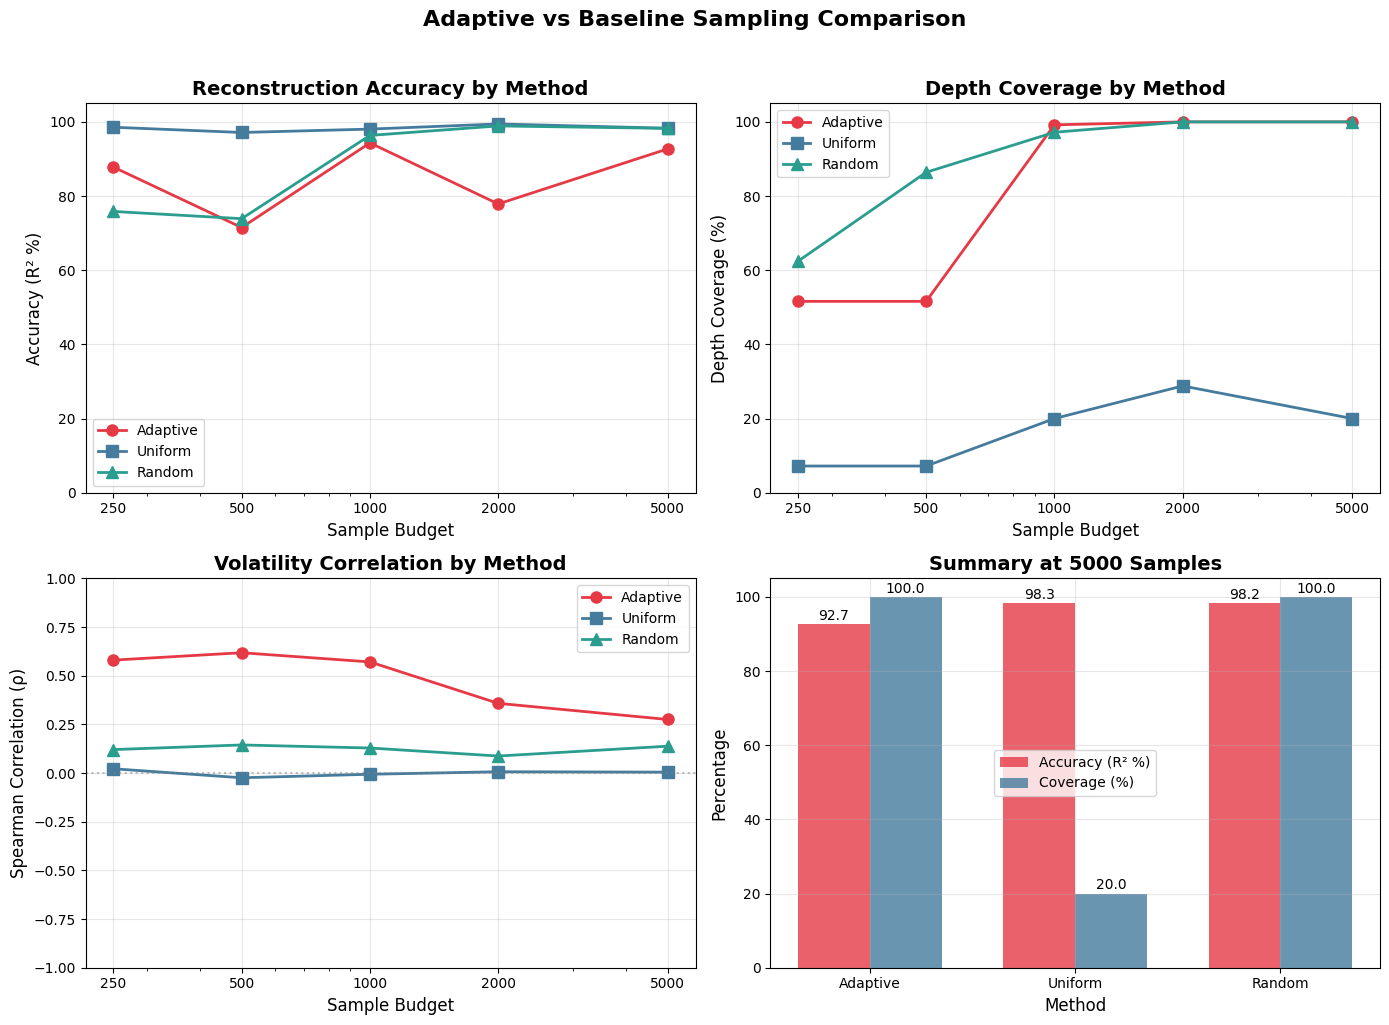


COMPARISON SUMMARY
       accuracy_r2                corr_volatility                depth_coverage_pct               
method    adaptive random uniform        adaptive random uniform           adaptive random uniform
budget                                                                                            
250          87.81  75.85   98.55            0.58   0.12    0.02               51.6   62.4     7.2
500          71.51  73.90   97.14            0.62   0.14   -0.02               51.6   86.4     7.2
1000         94.33  96.35   98.05            0.57   0.13   -0.01               99.2   97.2    20.0
2000         77.87  98.90   99.44            0.36   0.09    0.01              100.0  100.0    28.8
5000         92.72  98.24   98.29            0.27   0.14    0.00              100.0  100.0    20.0

Comparison results saved to: all_methods_comparison.csv


In [41]:
# ============================================
# BASELINE COMPARISON
# Generate uniform and random sampling baselines, then compare with adaptive
# ============================================

# Generate baseline plans (fast - no planning required)
budgets_to_test = [250, 500, 1000, 2000, 5000]
baseline_plans = generate_baseline_plans(budgets=budgets_to_test, save_path='baseline_plans.pkl')

# Compute metrics for baselines
baseline_metrics = compute_baseline_metrics(baseline_plans)

# Load adaptive results if not in memory
if 'results_df' not in globals():
    all_plans = load_plans('sampling_plans.pkl')
    results_df = compute_metrics(all_plans)

# Compare all methods and save comparison plot
all_comparison = compare_all_methods(
    results_df, 
    baseline_metrics, 
    save_path='result graphs/method_comparison.png'
)

# Save combined results to CSV
all_comparison.to_csv('all_methods_comparison.csv', index=False)
print("\nComparison results saved to: all_methods_comparison.csv")


Generating comparison plots...


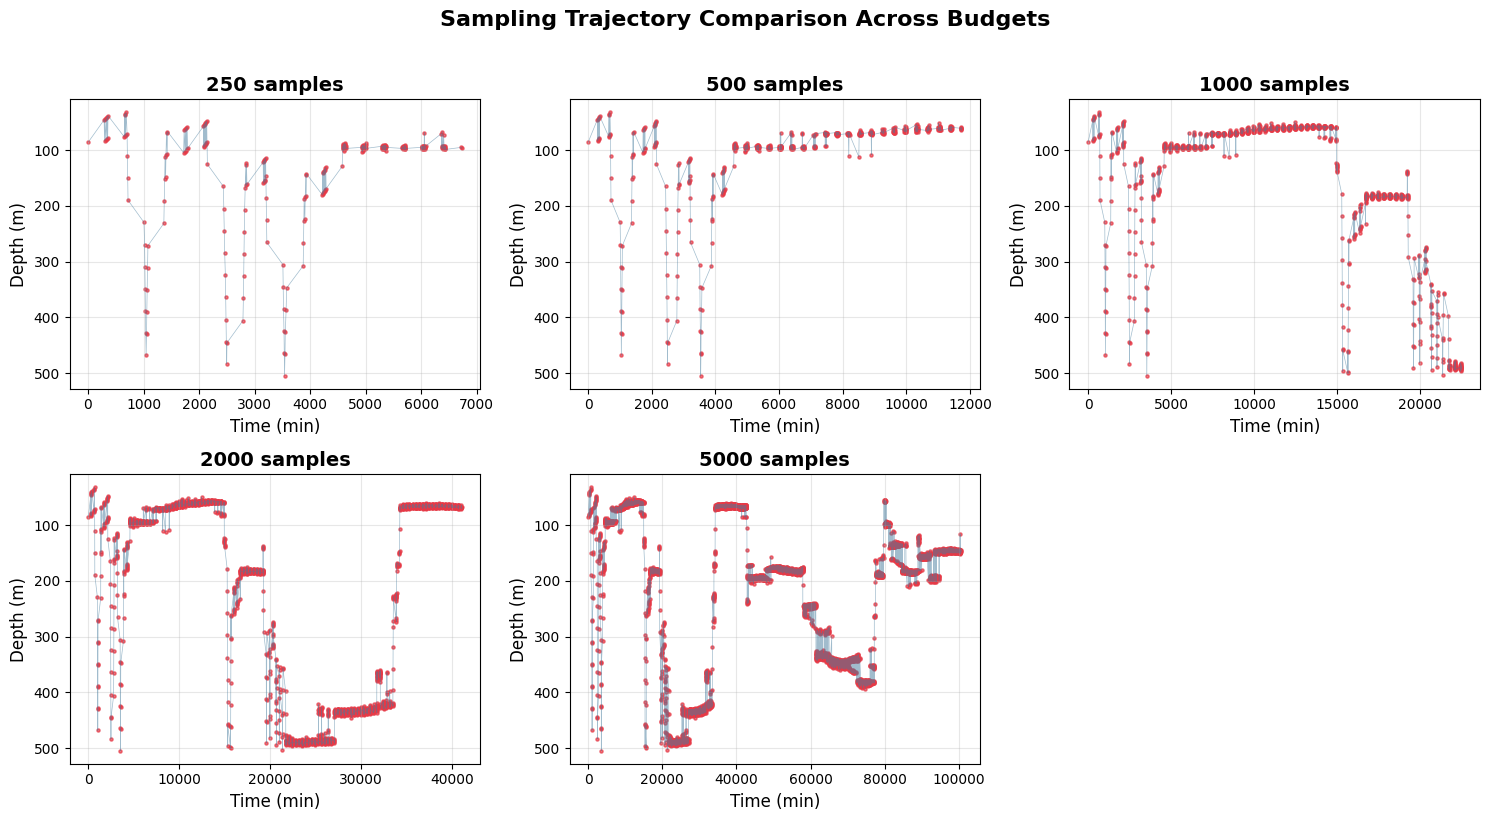

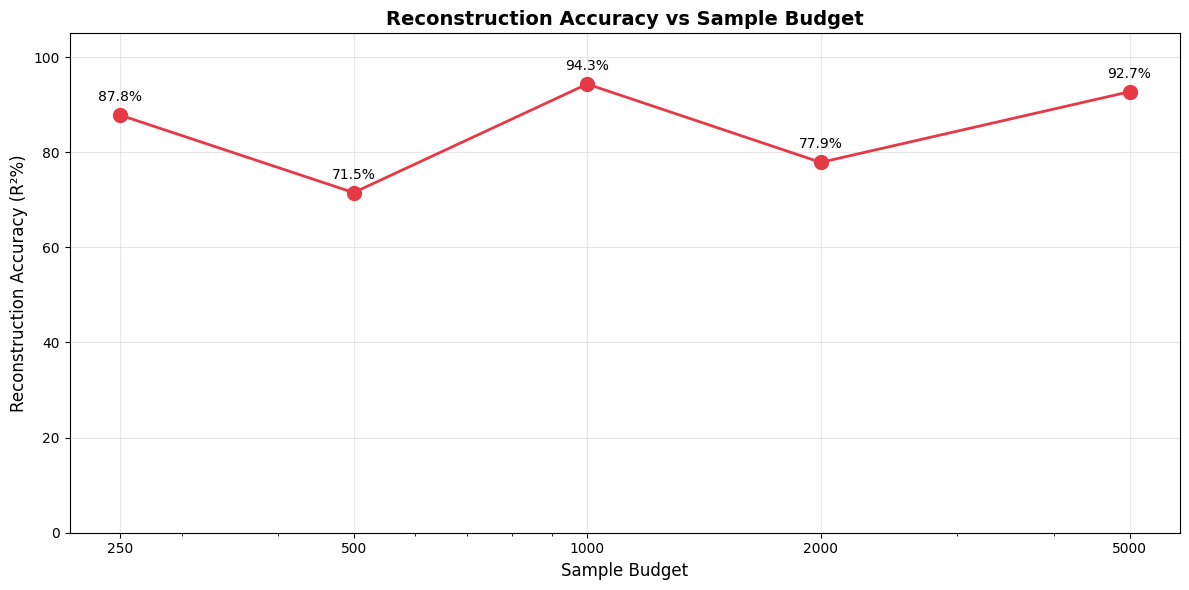


Generating individual plan plots...
  Plotting for budget=250...


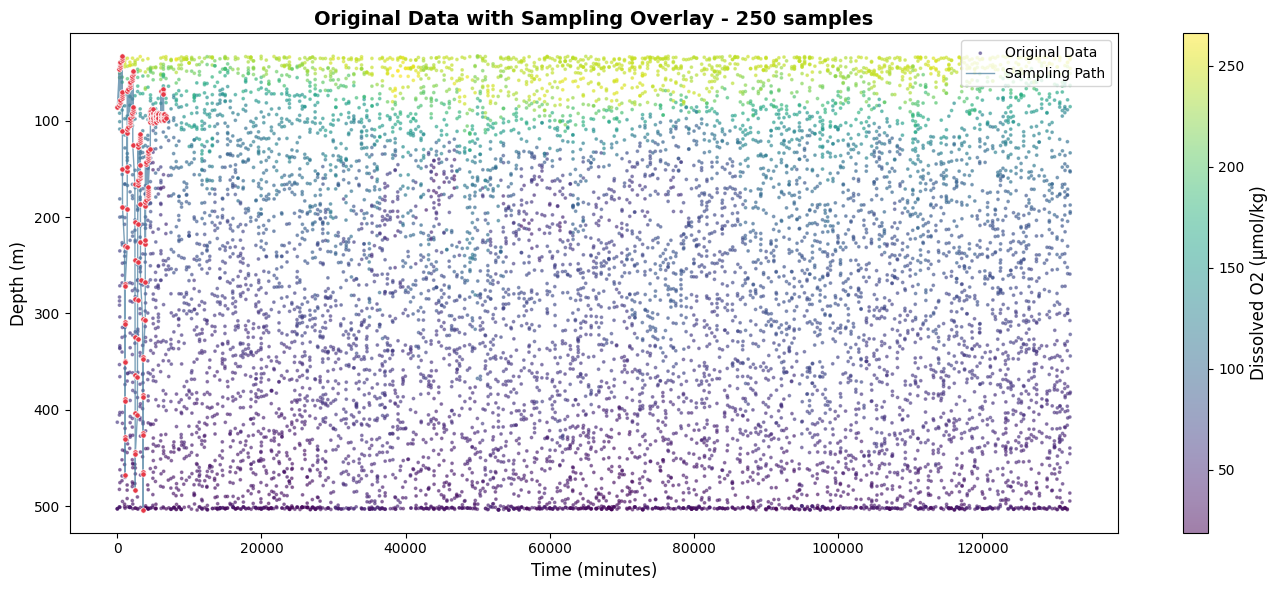

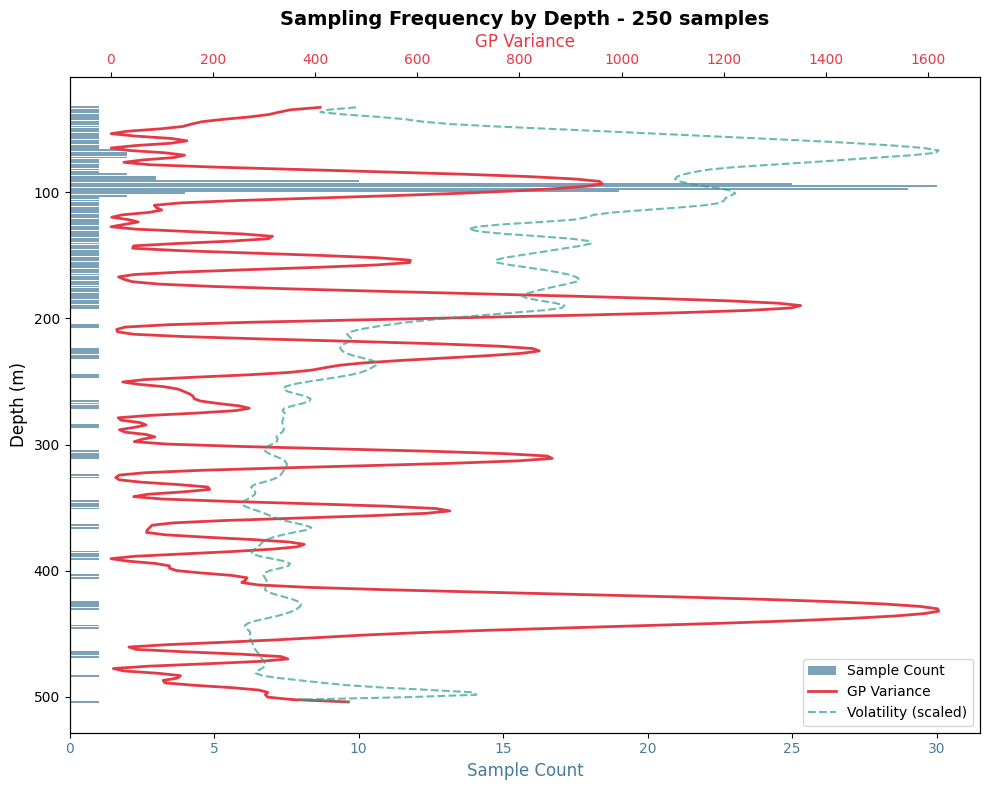

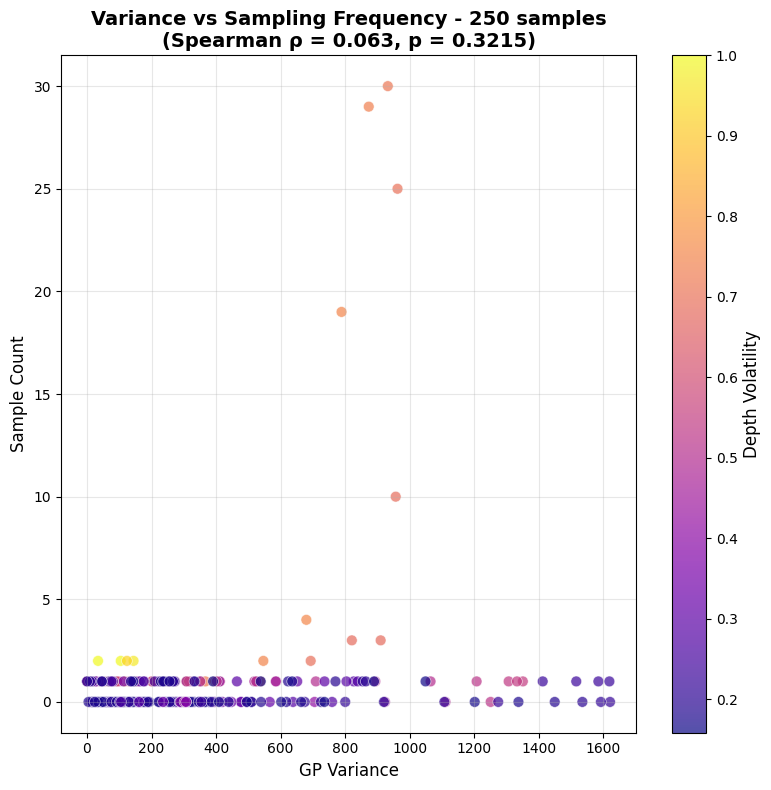

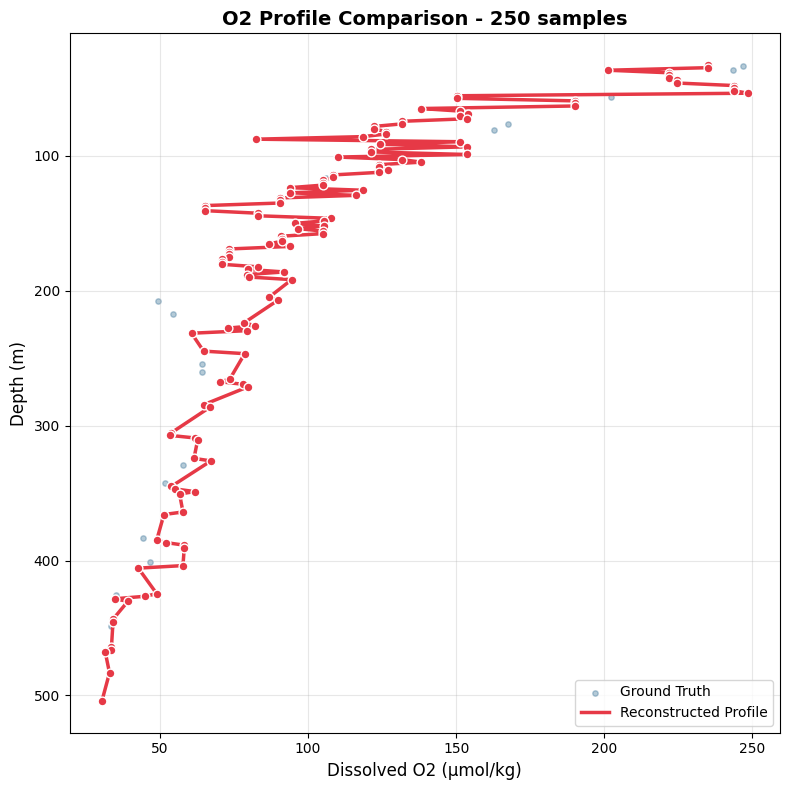

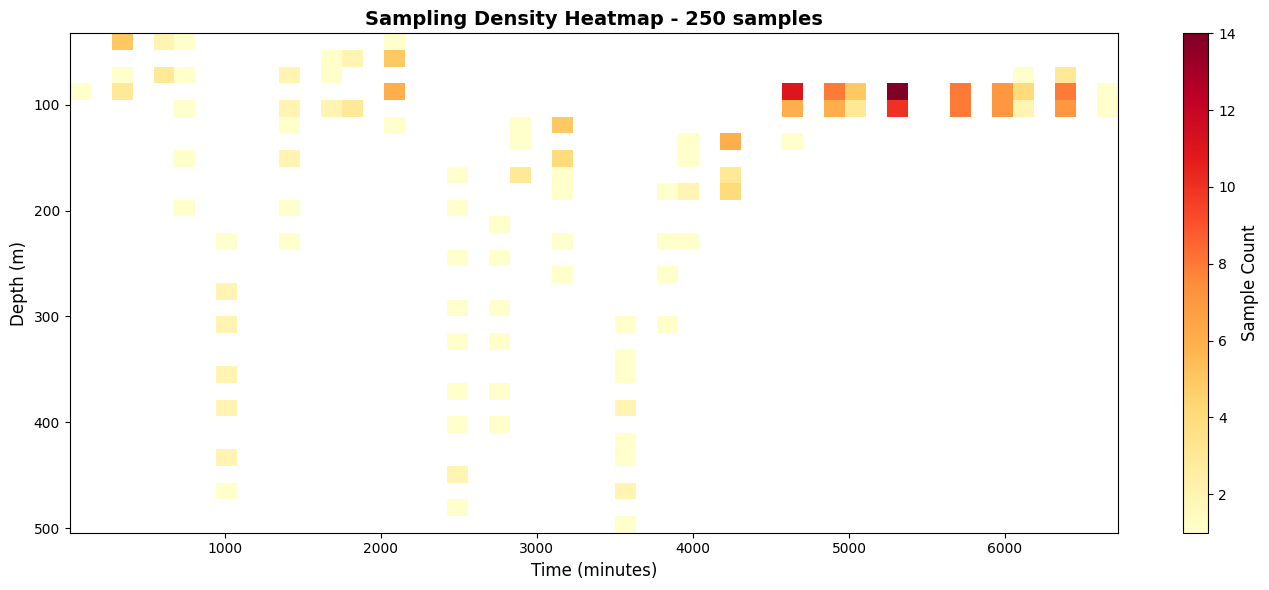

  Plotting for budget=500...


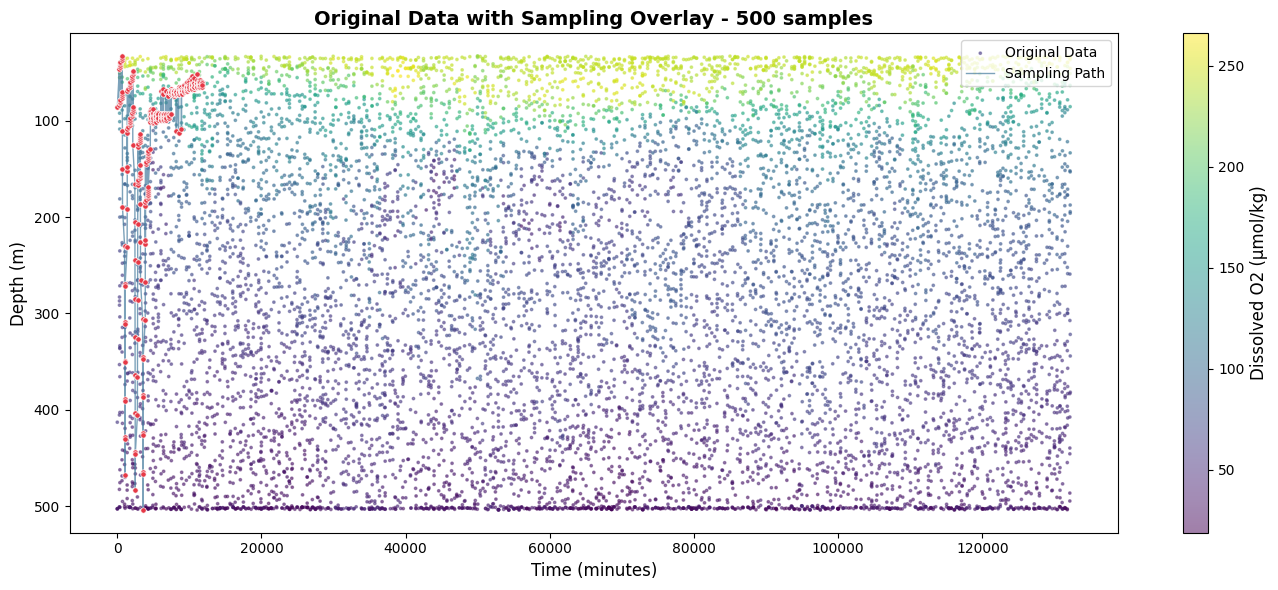

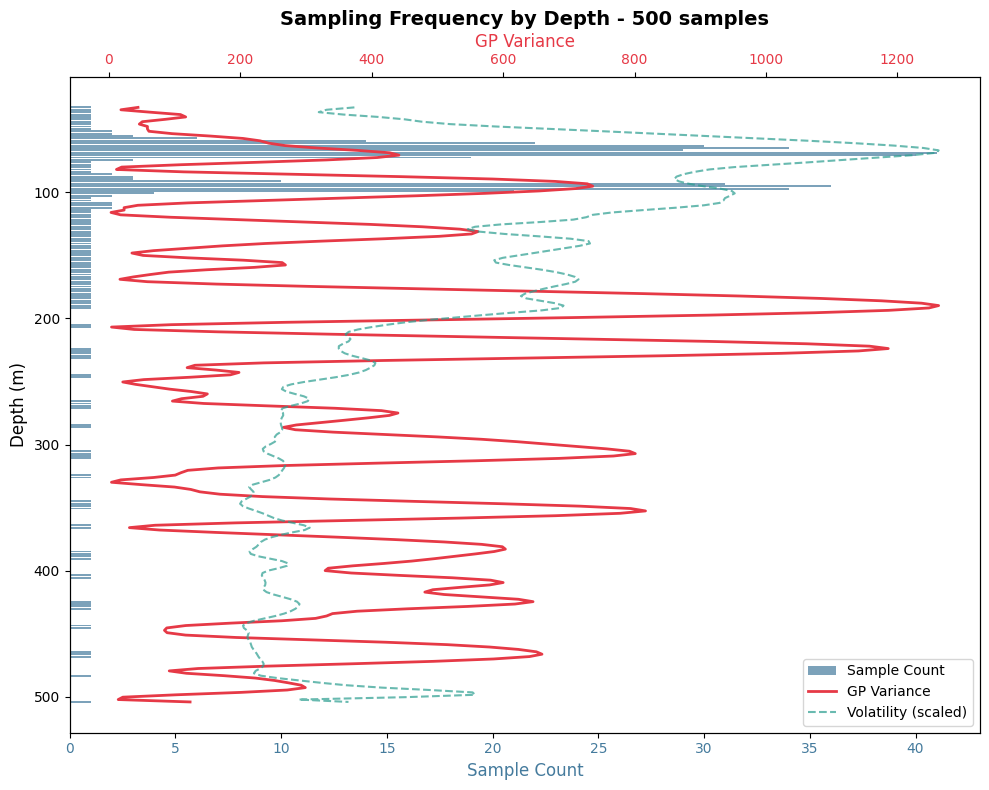

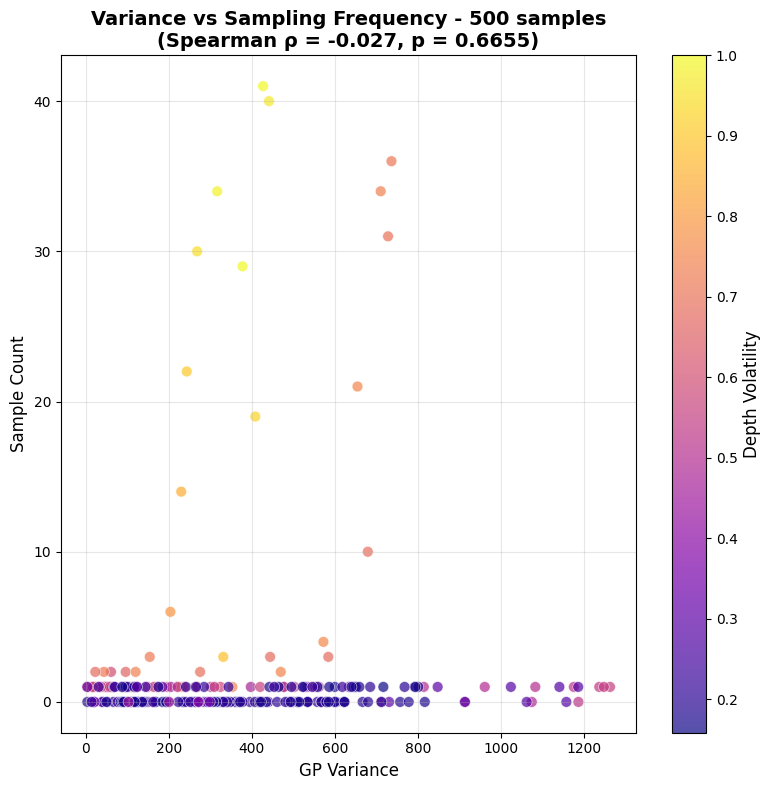

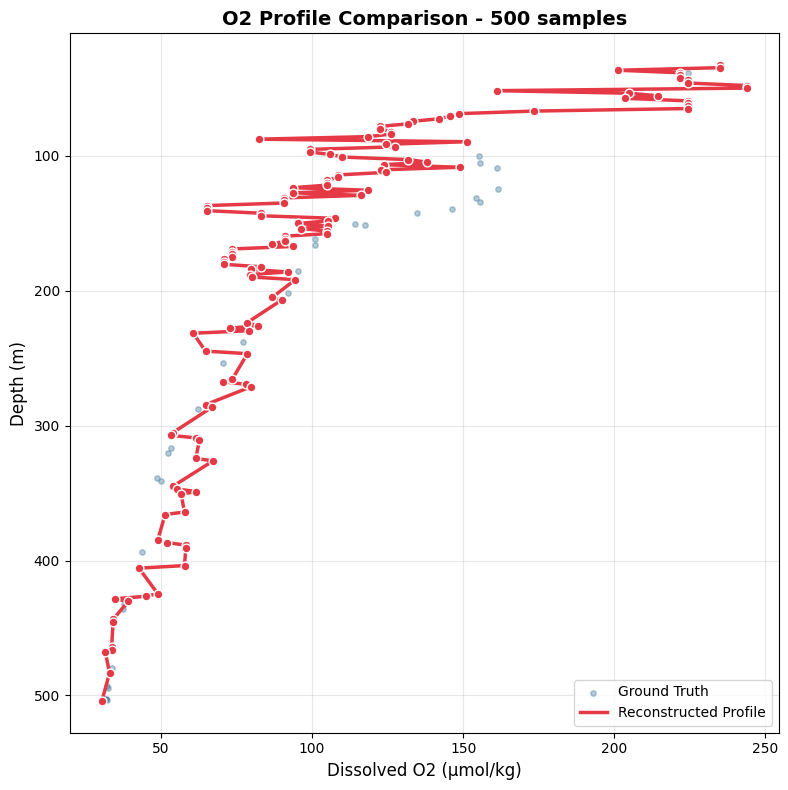

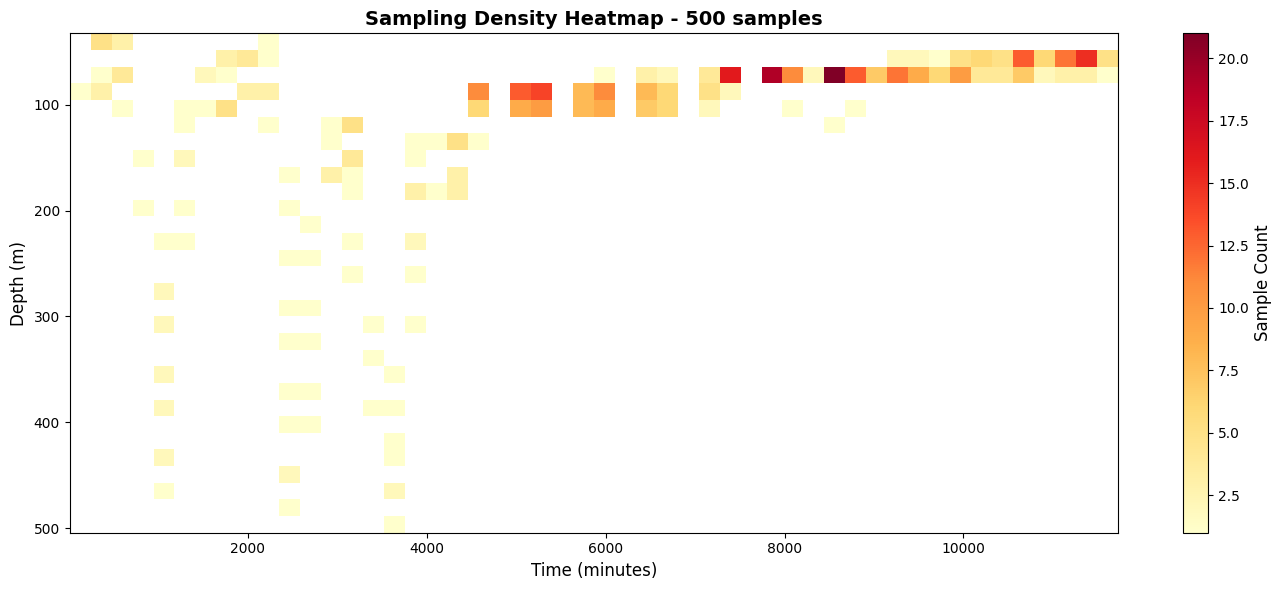

  Plotting for budget=1000...


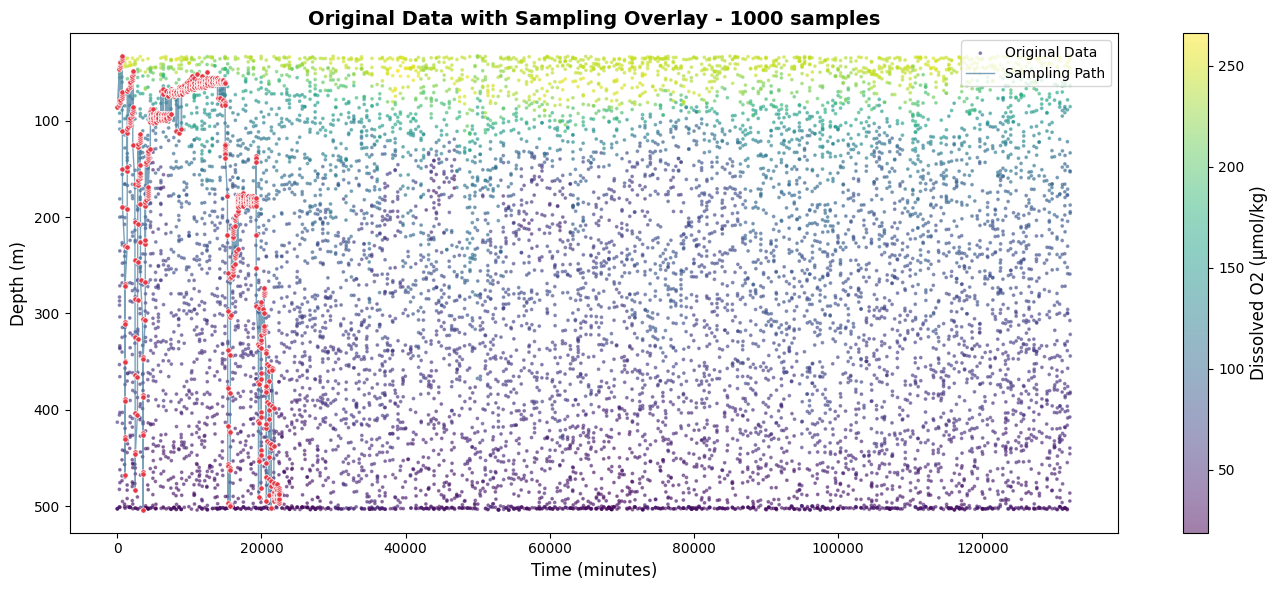

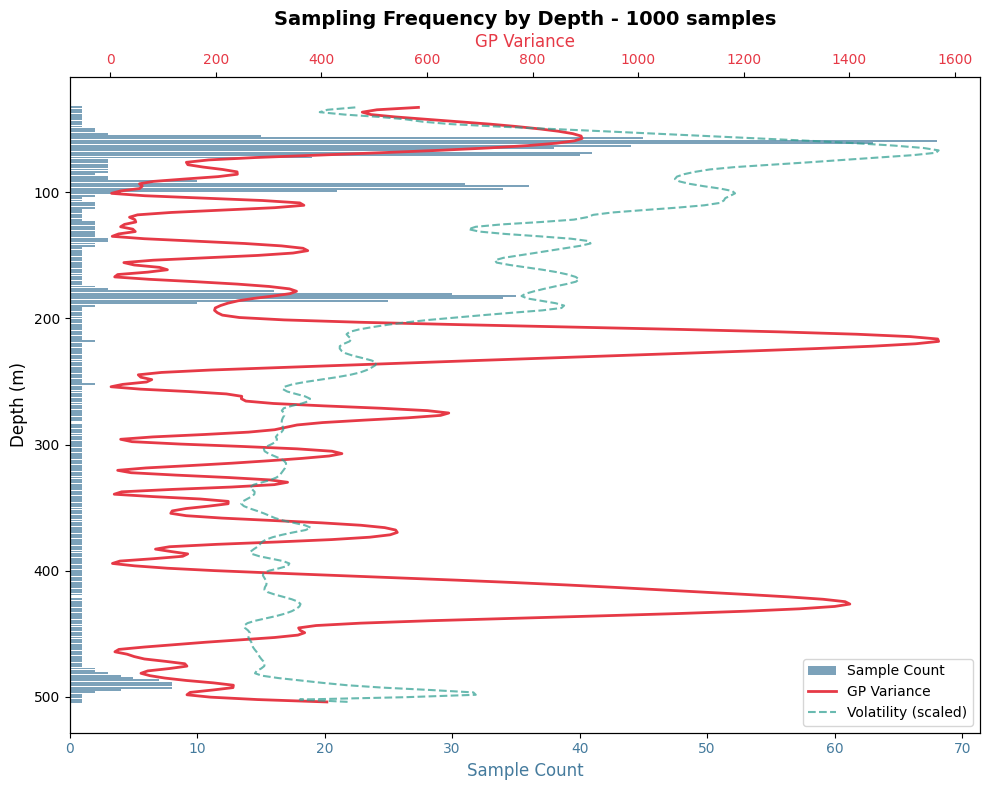

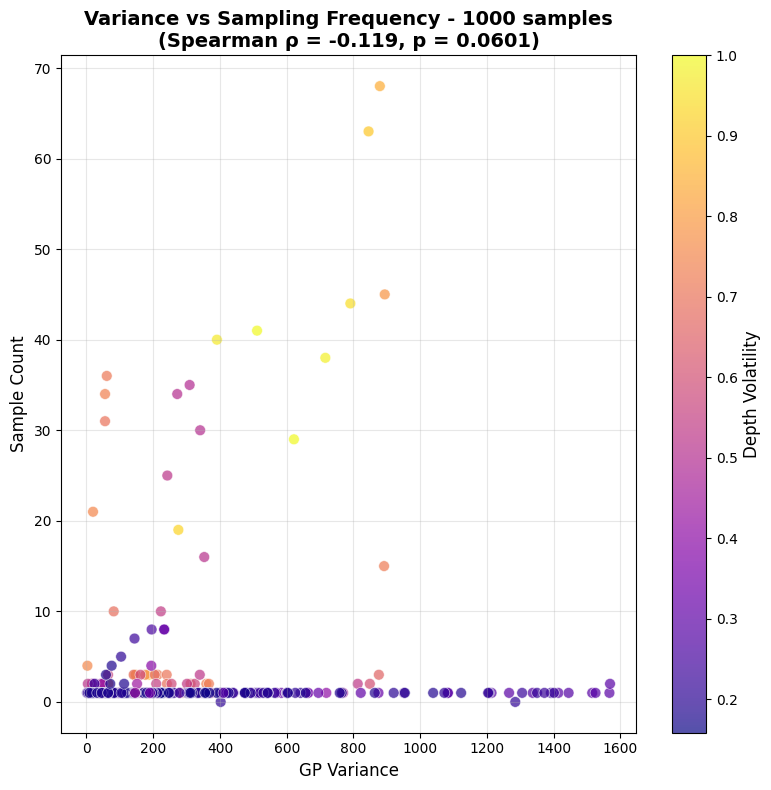

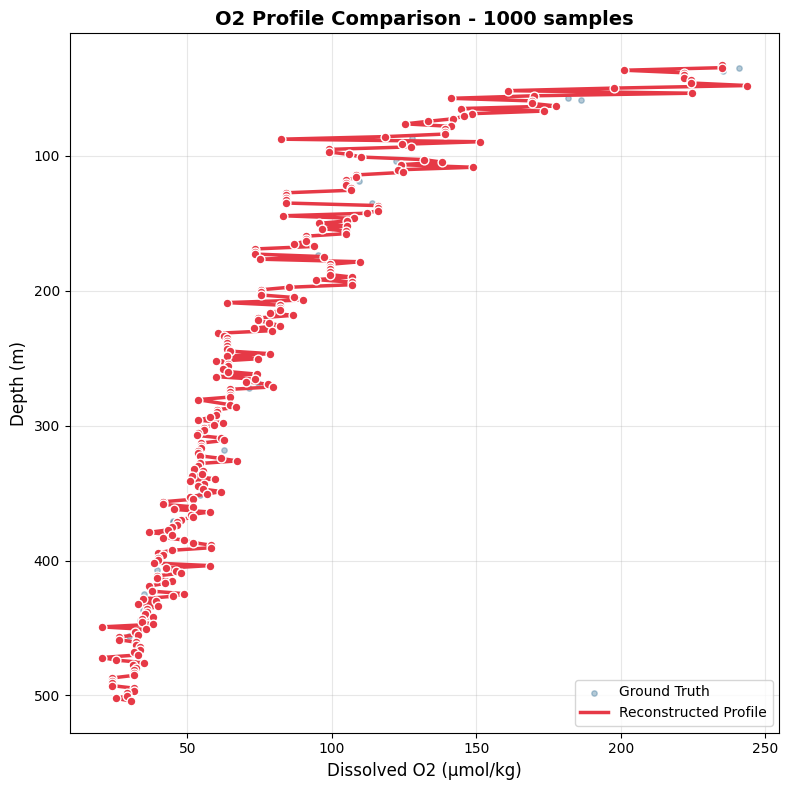

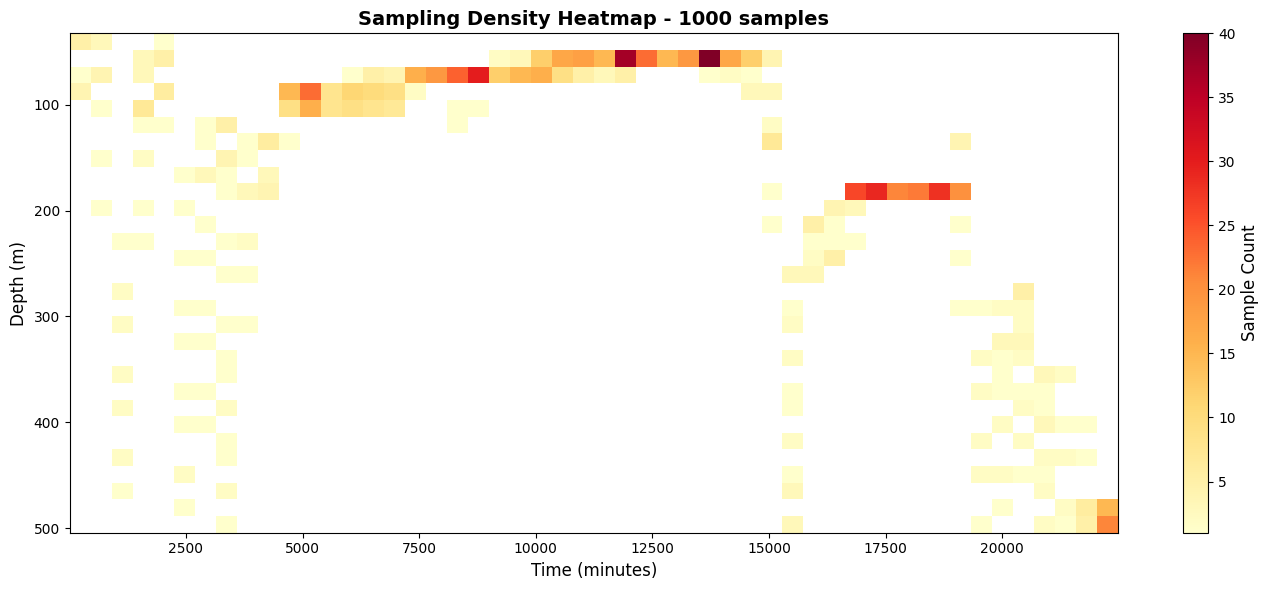

  Plotting for budget=2000...


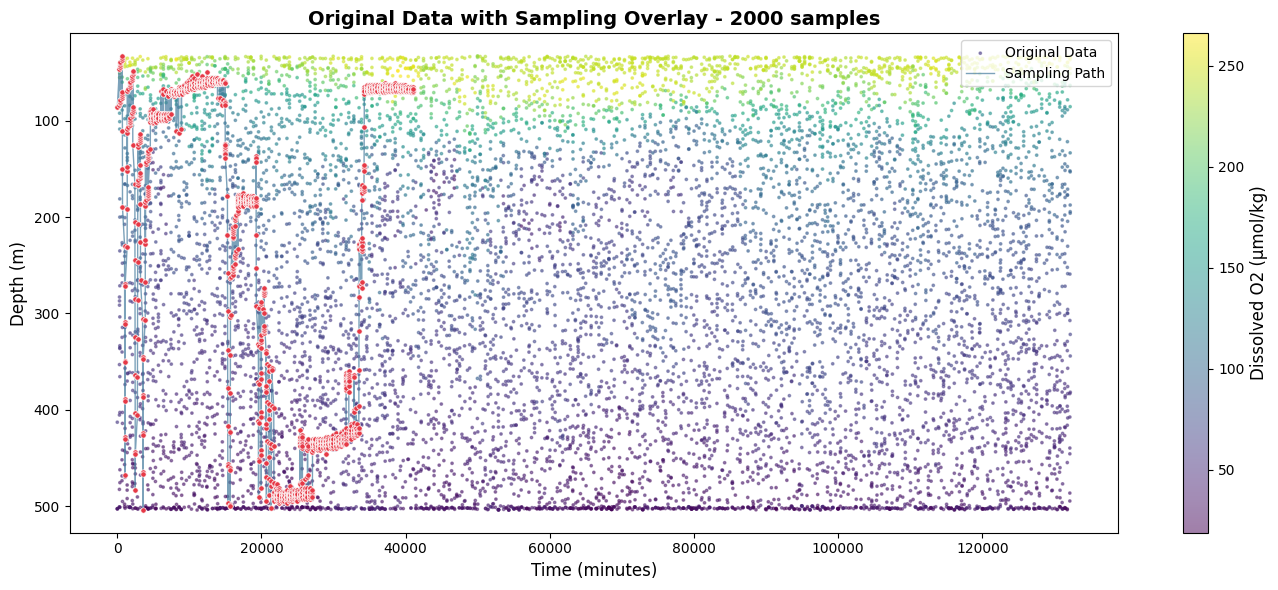

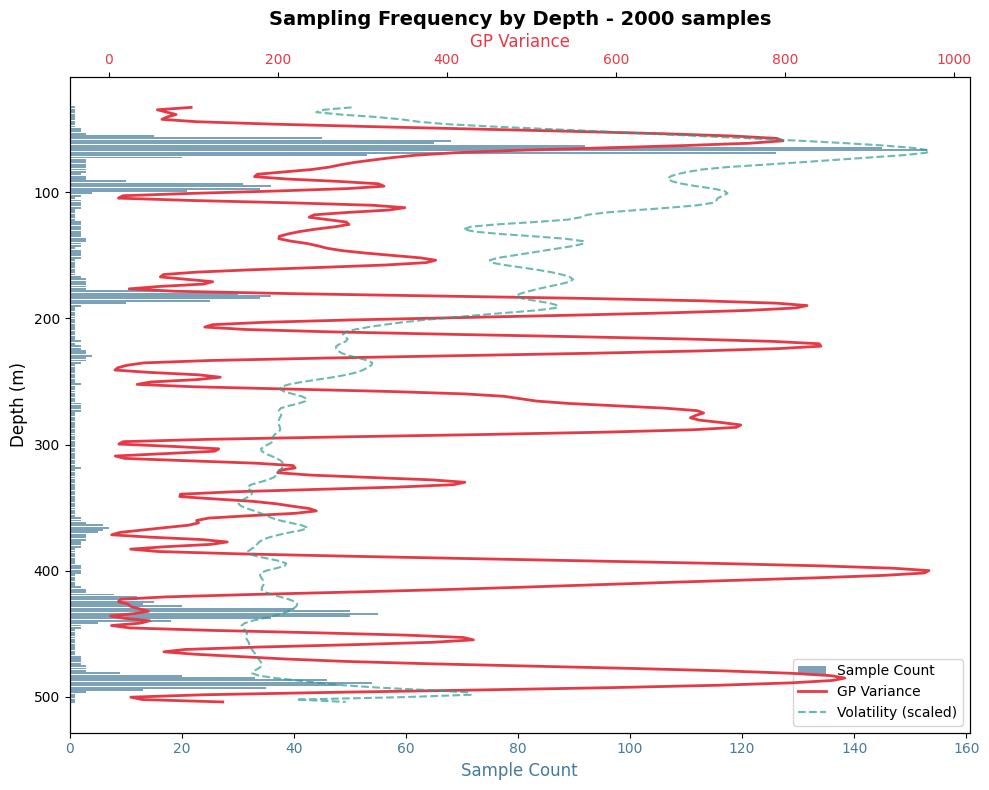

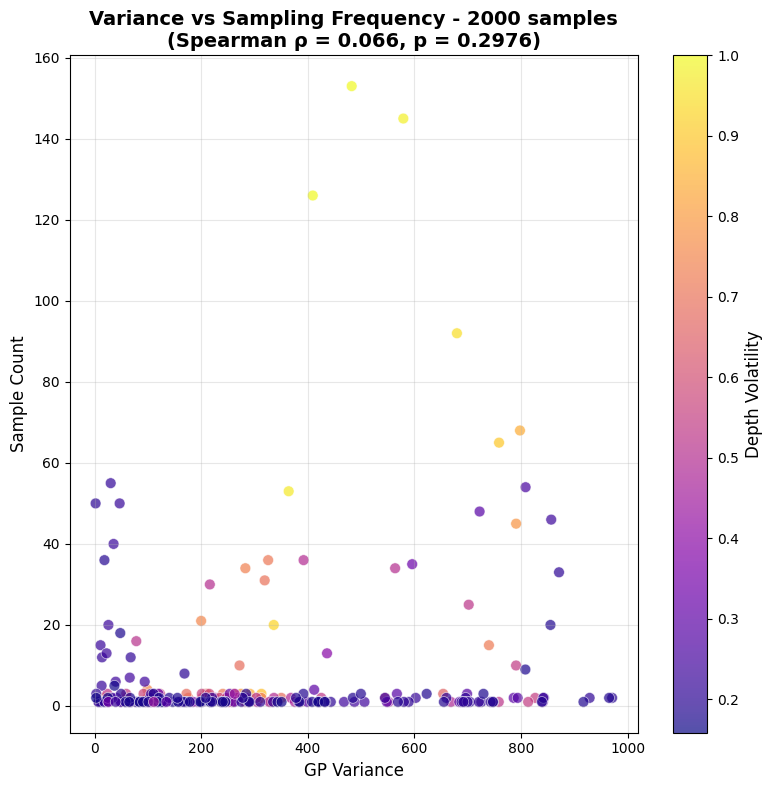

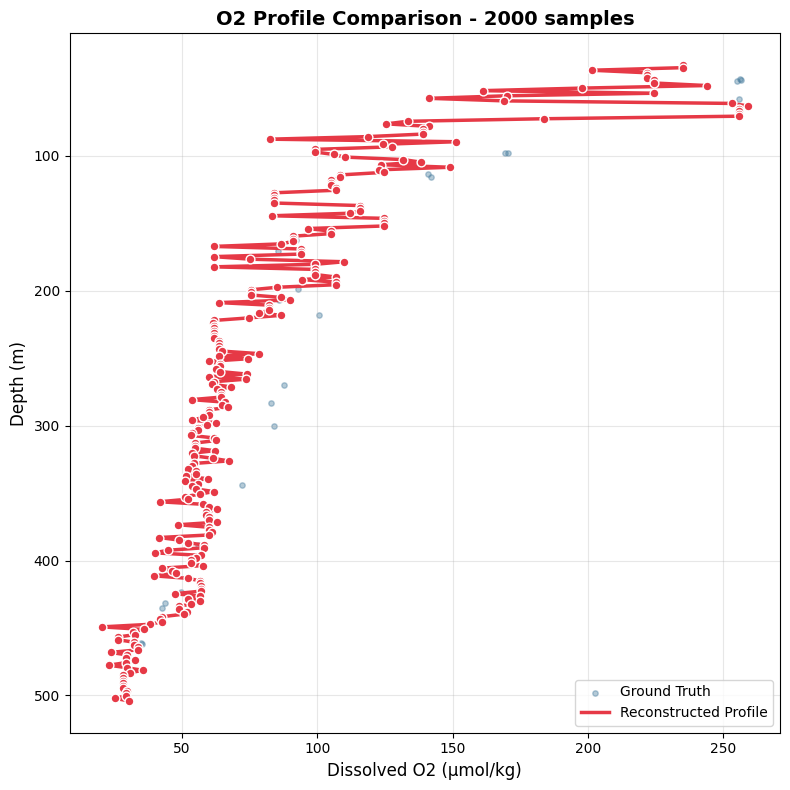

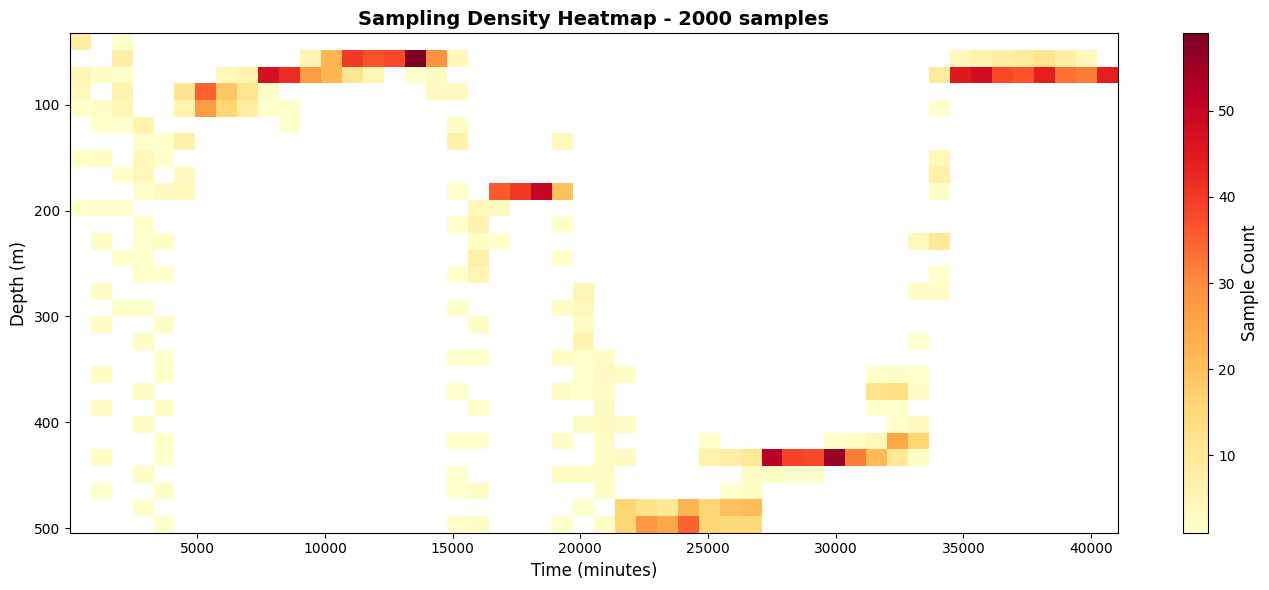

  Plotting for budget=5000...


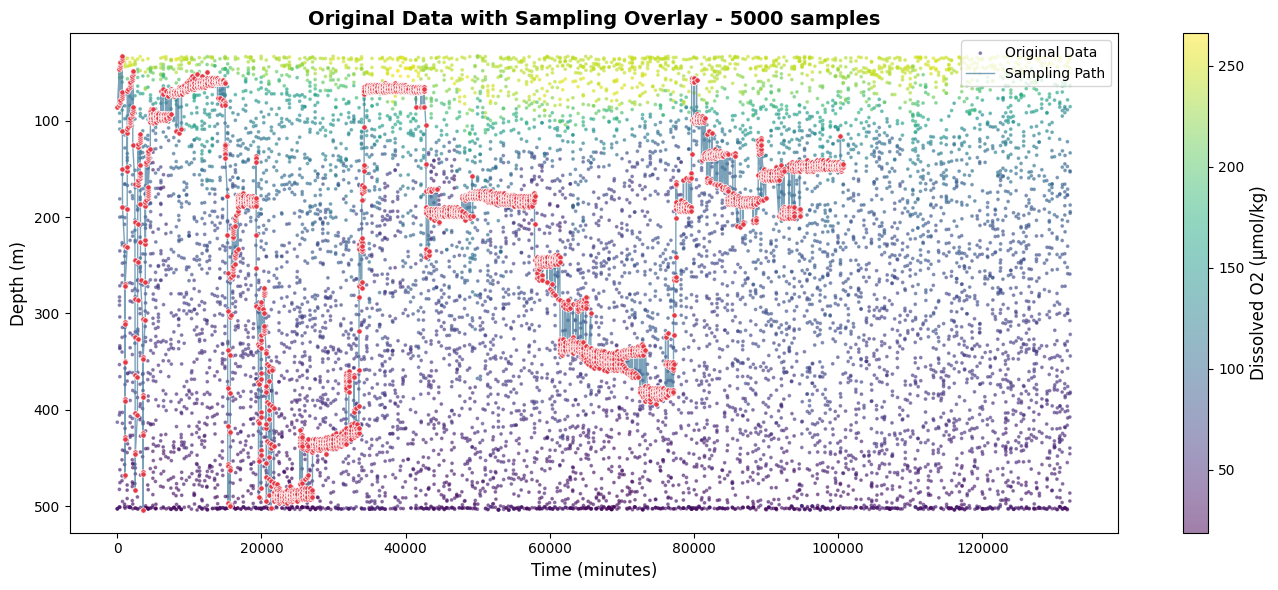

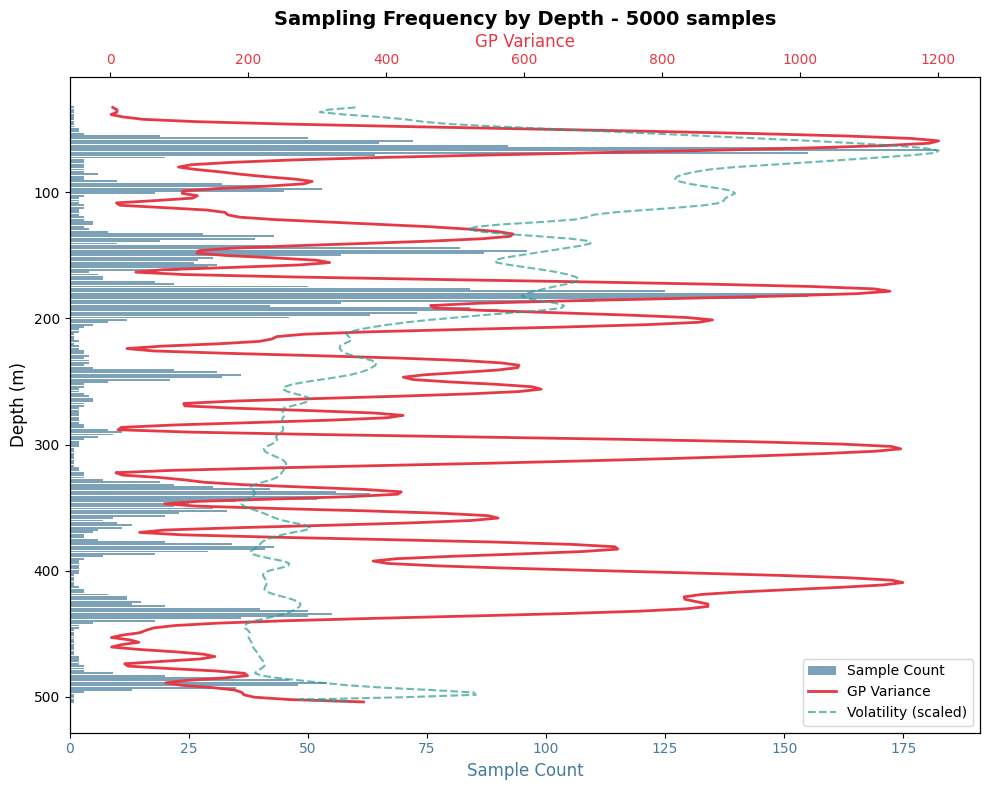

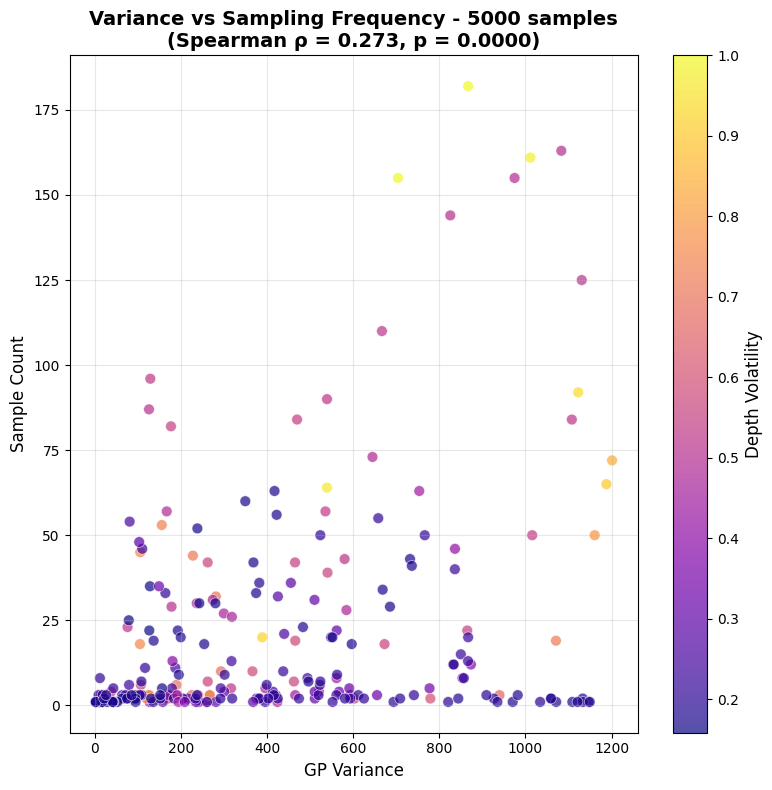

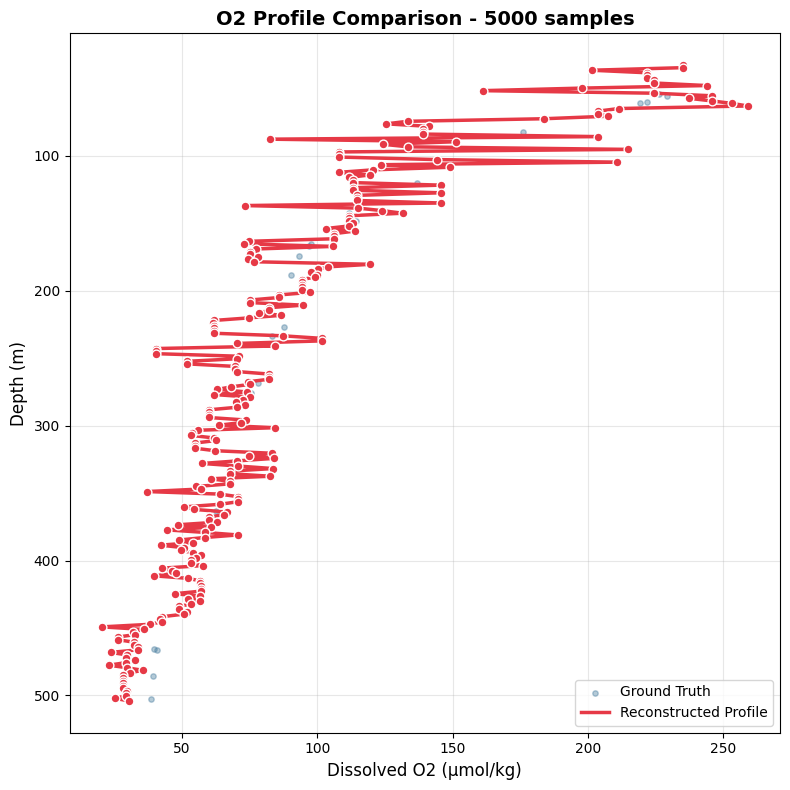

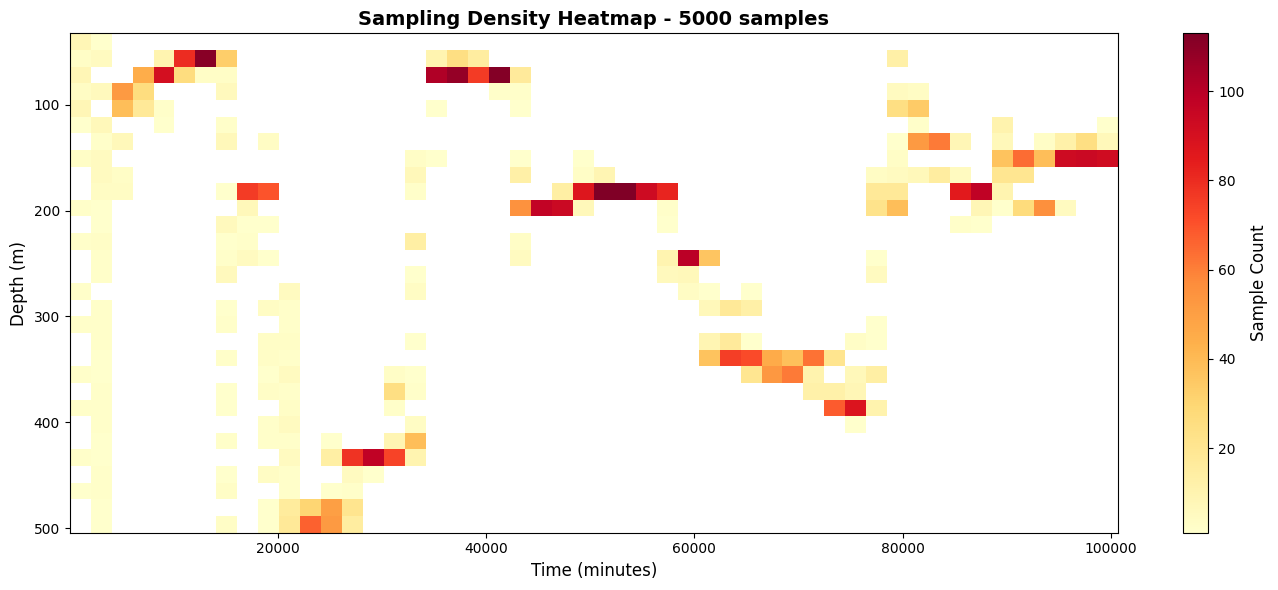


All plots generated!


In [42]:
# Generate all experiment plots and save to folder
# Load plans if not already in memory
if 'all_plans' not in globals():
    all_plans = load_plans('sampling_plans.pkl')
    results_df = compute_metrics(all_plans)

# Generate all plots and save to 'result graphs' folder
generate_all_experiment_plots(all_plans, results_df, save_dir='result graphs')


## Extra Non-experiment code
Primary used for debugging and small-scale testing during development

In [ ]:
# Debug function for inspecting RTDP planning behavior
# Useful for verifying action selection and priority computation

def debug_actions(start_depth_idx=None):
    """
    Run a debug trace of the RTDP planner to inspect action selection.
    
    Args:
        start_depth_idx: Starting depth index (defaults to most volatile depth)
    """
    if start_depth_idx is None:
        try:
            start_depth_idx = most_volatile_depth_idx
        except NameError:
            start_depth_idx = np.argmax(depth_volatility)
    
    # Initialize local state tracking
    local_lastvisittime = np.full(len(depth_grid), -np.inf).copy()
    local_visit_counts = np.zeros(len(depth_grid), dtype=int)
    
    mdp = MDP(local_lastvisittime, local_visit_counts)
    planner = RTDPPlanner(mdp)
    state = State(depth_idx=start_depth_idx, time_step=0)
    
    mdp.visit_counts = np.zeros(len(depth_grid), dtype=int)
    mdp.last_visit_time = np.full(len(depth_grid), -np.inf)
    planner.V.clear()
    planner.policy.clear()
    print("State reset - all visits=0")


    print(f"Start depth: {depth_grid[start_depth_idx]:.0f}m (idx={start_depth_idx})")
    print("Next 10 actions:")
    
    t_idx = min(state.time_step, len(three_month) - 1)
    t_val = float(three_month.iloc[t_idx]['all_time'])
    
    # Print priorities at current depth and nearby depths
    print(f"\nPriorities at time {t_val:.1f} min:")
    for d_idx in [max(0, start_depth_idx-2), start_depth_idx, min(len(depth_grid)-1, start_depth_idx+2)]:
        # Use depth_priority() for consistency, but show breakdown for debugging
        prio = depth_priority(t_val, d_idx, local_lastvisittime, visit_counts=local_visit_counts)
        var = gp_variance_at(t_val, d_idx)  # For display only
        if local_lastvisittime[d_idx] == -np.inf:
            dtsince = np.inf
        else:
            dtsince = t_val - local_lastvisittime[d_idx]
        vol = depth_volatility[d_idx]
        w = temporal_weight(dtsince, vol)
        print(f"  Depth {d_idx} ({depth_grid[d_idx]:.0f}m): var={var:.3f}, dt={dtsince:.1f}, vol={vol:.3f}, w={w:.3f}, prio={prio:.3f}")

    for i in range(30):
        # Re-simulate from current state to update policy
        planner.simulate(state, n_rollouts=20)
        
        # Show priorities at current depth and nearby depths
        t_idx = min(state.time_step, len(three_month) - 1)
        t_val = float(three_month.iloc[t_idx]['all_time'])
        if i < 3:  # Show for first few steps
            print(f"\n  Step {i} - Priorities before action:")
            for d_idx in [max(0, state.depth_idx-1), state.depth_idx, min(len(depth_grid)-1, state.depth_idx+1)]:
                prio = depth_priority(t_val, d_idx, local_lastvisittime, visit_counts=local_visit_counts)
                visits = local_visit_counts[d_idx]
                print(f"    Depth {d_idx} ({depth_grid[d_idx]:.0f}m): prio={prio:.2f}, visits={visits}")
        
        # Show Q-values for all actions
        if i < 3:
            print(f"\n  Step {i} - Q-values for each action:")
            for action_test in Action:
                succs_test = mdp.successors(state, action_test)
                if succs_test:
                    next_s_test, _, rew_test = succs_test[0]
                    v_next_test = planner.V.get(next_s_test, planner.heuristic(next_s_test))
                    q_val = rew_test + 0.95 * v_next_test
                    print(f"    {action_test.name:8s}: reward={rew_test:7.2f}, V_next={v_next_test:7.2f}, Q={q_val:7.2f}")
        
        action = planner.greedy_action(state)
        print(f"  Step {i}: {action.name} → depth_idx={state.depth_idx} ({depth_grid[state.depth_idx]:.0f}m)")

        succs = mdp.successors(state, action)
        if not succs:
            print("  DEAD END!")
            break
        next_state = succs[0][0]
        
        # Update visit tracking after sampling
        t_idx = min(next_state.time_step, len(three_month) - 1)
        t_val = float(three_month.iloc[t_idx]['all_time'])
        local_lastvisittime[next_state.depth_idx] = t_val
        local_visit_counts[next_state.depth_idx] += 1
        
        # Synchronize MDP state
        mdp.last_visit_time = local_lastvisittime
        mdp.visit_counts = local_visit_counts
        
        # Clear stale cache entries
        should_clear_v = local_visit_counts[next_state.depth_idx] >= 2
        planner.clear_cache(clear_v_values=should_clear_v)
        
        # Show sampling result
        prio_after = depth_priority(t_val, next_state.depth_idx, local_lastvisittime, visit_counts=local_visit_counts)
        var_after = gp_variance_at(t_val, next_state.depth_idx)  # For display only
        w_after = temporal_weight(0.0, depth_volatility[next_state.depth_idx])  # dt=0 after sampling
        print(f"    After sampling at {depth_grid[next_state.depth_idx]:.0f}m: var={var_after:.3f}, w={w_after:.3f}, prio={prio_after:.3f}, visits={local_visit_counts[next_state.depth_idx]}")
        
        state = next_state
        
        # Check priorities at new state
        if i < 3:
            prio_curr = depth_priority(t_val, state.depth_idx, local_lastvisittime, visit_counts=local_visit_counts)
            print(f"    Priority at new state ({depth_grid[state.depth_idx]:.0f}m): prio={prio_curr:.3f}")

debug_actions(start_depth_idx=49)